In [90]:
import pandas as pd
import geopandas as gpd
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

#Added
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.multicomp import pairwise_tukeyhsd


#Added for Rq2
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import precision_recall_curve, average_precision_score


In [5]:
df_geo = gpd.read_file("cleaned_data_plus_geospatial_date_v2.geojson")

Going to list out the columns we will be working with (and remove a couple remaining demographic-focused variables:

In [6]:
print(df_geo.columns)

Index(['ZCTA5CE20', 'GEOID20', 'GEOIDFQ20', 'CLASSFP20', 'MTFCC20',
       'FUNCSTAT20', 'ALAND20', 'AWATER20', 'INTPTLAT20', 'INTPTLON20',
       'RowID', 'CrimeDateTime', 'CrimeCode', 'Location', 'Latitude',
       'Longitude', 'PremiseType', 'NAME', 'CLASS', 'WEAPON', 'VIOLENT_CR',
       'VIO_PROP_CFS', 'zip', 'population', 'density', 'age_median',
       'family_size', 'income_household_median', 'home_ownership',
       'home_value', 'rent_median', 'education_less_highschool',
       'education_highschool', 'education_college_or_above',
       'unemployment_rate', 'disabled', 'poverty', 'PremiseType_Grouped',
       'Time_Category', 'Socioeconomic_Index', 'crime_count',
       'crime_per_capita', 'geometry'],
      dtype='object')


In [7]:
df_geo.drop(columns=['age_median', 'family_size'])

ZCTA5CE20 GEOID20       GEOIDFQ20 CLASSFP20 MTFCC20 FUNCSTAT20  \
0          21206   21206  860Z200US21206        B5   G6350          S   
1          21206   21206  860Z200US21206        B5   G6350          S   
2          21206   21206  860Z200US21206        B5   G6350          S   
3          21206   21206  860Z200US21206        B5   G6350          S   
4          21206   21206  860Z200US21206        B5   G6350          S   
...          ...     ...             ...       ...     ...        ...   
321349     21207   21207  860Z200US21207        B5   G6350          S   
321350     21207   21207  860Z200US21207        B5   G6350          S   
321351     21207   21207  860Z200US21207        B5   G6350          S   
321352     21207   21207  860Z200US21207        B5   G6350          S   
321353     21207   21207  860Z200US21207        B5   G6350          S   

         ALAND20  AWATER20   INTPTLAT20    INTPTLON20  ...  \
0       18784007      3869  +39.3384283  -076.5388766  ...   
1       18784007      3869  +39.3384283  -076.5388766  ...   
2       18784007      3869  +39.3384283  -076.5388766  ...   
3       18784007      3869  +39.3384283  -076.5388766  ...   
4       18784007      3869  +39.3384283  -076.5388766  ...   
...          ...       ...          ...           ...  ...   
321349  26793537     93870  +39.3241672  -076.7194841  ...   
321350  26793537     93870  +39.3241672  -076.7194841  ...   
321351  26793537     93870  +39.3241672  -076.7194841  ...   
321352  26793537     93870  +39.3241672  -076.7194841  ...   
321353  26793537     93870  +39.3241672  -076.7194841  ...   

        education_college_or_above unemployment_rate disabled poverty  \
0                             24.3               5.2     12.4    12.6   
1                             24.3               5.2     12.4    12.6   
2                             24.3               5.2     12.4    12.6   
3                             24.3               5.2     12.4    12.6   
4                             24.3               5.2     12.4    12.6   
...                            ...               ...      ...     ...   
321349                        28.5               7.3     15.4    15.2   
321350                        28.5               7.3     15.4    15.2   
321351                        28.5               7.3     15.4    15.2   
321352                        28.5               7.3     15.4    15.2   
321353                        28.5               7.3     15.4    15.2   

        PremiseType_Grouped  Time_Category Socioeconomic_Index crime_count  \
0           Non-Residential      Afternoon            0.465374       16502   
1           Non-Residential      Afternoon            0.465374       16502   
2           Non-Residential        Evening            0.465374       16502   
3           Non-Residential      Afternoon            0.465374       16502   
4           Non-Residential        Morning            0.465374       16502   
...                     ...            ...                 ...         ...   
321349      Non-Residential      Afternoon            0.425149        3470   
321350      Non-Residential      Afternoon            0.425149        3470   
321351      Non-Residential        Evening            0.425149        3470   
321352      Non-Residential        Evening            0.425149        3470   
321353      Non-Residential      Afternoon            0.425149        3470   

       crime_per_capita                                           geometry  
0          32344.178753  POLYGON ((-76.57655 39.33386, -76.57616 39.334...  
1          32344.178753  POLYGON ((-76.57655 39.33386, -76.57616 39.334...  
2          32344.178753  POLYGON ((-76.57655 39.33386, -76.57616 39.334...  
3          32344.178753  POLYGON ((-76.57655 39.33386, -76.57616 39.334...  
4          32344.178753  POLYGON ((-76.57655 39.33386, -76.57616 39.334...  
...                 ...                                                ...  
321349      6703.371004  POLYGON

In [8]:
df_geo.shape

(321354, 43)

In [9]:
#removing a couple datapoints that were very old
df_geo = df_geo[df_geo["CrimeDateTime"] >= "2011-01-01"]

In [10]:
df_geo.shape

(321240, 43)

In [11]:
#Before analysis, we will define a few things that we will use later on

#Some calculations that get used a number of times
df_geo['CrimeHour'] = pd.to_datetime(df_geo['CrimeDateTime']).dt.hour
df_geo['CrimeDay'] = pd.to_datetime(df_geo['CrimeDateTime']).dt.dayofweek
df_geo['CrimeMonth'] = pd.to_datetime(df_geo['CrimeDateTime']).dt.month

#A filtering function instead of hardcoding this for each additional filter on crime categories
def filter_crime_data(df, exclude_categories=None, include_categories=None):
    filtered_df = df.copy()

    if exclude_categories:
        filtered_df = filtered_df[~filtered_df['CrimeCategory'].isin(exclude_categories)]

    if include_categories:
        filtered_df = filtered_df[filtered_df['CrimeCategory'].isin(include_categories)]

    return filtered_df

We will also get a couple dictionaries out of the way at the beginning.

In [12]:
#First, we can make a list of all the crime 'Names' so we bin them appropriately.
#print(df_geo['NAME'].unique())
#this made a list of 80 unique names

In [13]:
# Dictionary to map crime types into broader categories
crime_mapping = {
    # Violent Crimes
    'AGG. ASSLT.- HAND': 'Violent Crimes',
    'AGG. ASSLT.- OTH.': 'Violent Crimes',
    'AGG. ASSLT.- CUT': 'Violent Crimes',
    'AGG. ASSLT.- GUN': 'Violent Crimes',
    'COMMON ASSAULT': 'Violent Crimes',
    'SHOOTING': 'Violent Crimes',
    'MURDER': 'Violent Crimes',
    'MURDER ': 'Violent Crimes',

    # Robbery (Armed/Unarmed)
    'ROBB HWY (UA)': 'Robbery',
    'ROBB HWY FIREARM': 'Robbery',
    'ROBB HWY OTHER WPN': 'Robbery',
    'ROBB HWY KNIFE': 'Robbery',
    'ROBB MISC FIREARM': 'Robbery',
    'ROBB MISC KNIFE': 'Robbery',
    'ROBB MISC OTHER WPN': 'Robbery',
    'ROBB MISC (A)': 'Robbery',
    'ROBB MISC (UA)': 'Robbery',
    'ROBB CARJACK (UA)': 'Robbery',
    'ROBB CARJACK-FIREARM': 'Robbery',
    'ROBB CARJACK-OTHER WPN': 'Robbery',
    'ROBB CARJACK-KNIFE': 'Robbery',
    'ROBB RESIDENCE (UA)': 'Robbery',
    'ROBB RESIDENCE FIREARM': 'Robbery',
    'ROBB RESIDENCE KNIFE': 'Robbery',
    'ROBB RESIDENCE OTHER WPN': 'Robbery',
    'ROBB RESIDENCE (A)': 'Robbery',
    'ROBB COMM FIREARM': 'Robbery',
    'ROBB COMM KNIFE': 'Robbery',
    'ROBB COMM OTHER WPN': 'Robbery',
    'ROBB COMM (UA)': 'Robbery',
    'ROBB COMM (A)': 'Robbery',
    'ROBB CONV STORE FIREARM': 'Robbery',
    'ROBB CONV STORE OTHER WPN': 'Robbery',
    'ROBB CONV STORE KNIFE': 'Robbery',
    'ROBB CONV STORE (UA)': 'Robbery',
    'ROBB CONV STORE (A)': 'Robbery',
    'ROBB GAS STATION FIREARM': 'Robbery',
    'ROBB GAS STATION OTHER WPN': 'Robbery',
    'ROBB GAS STATION KNIFE': 'Robbery',
    'ROBB GAS STATION (UA)': 'Robbery',
    'ROBB GAS STATION (A)': 'Robbery',
    'ROBB BANK FIREARM': 'Robbery',
    'ROBB BANK OTHER WPN': 'Robbery',
    'ROBB BANK KNIFE': 'Robbery',
    'ROBB BANK (UA)': 'Robbery',
    'ROBB BANK (A)': 'Robbery',

    # Sexual Crimes
    'RAPE (FORCE)': 'Sexual Crimes',
    'RAPE (ATTEMPT)': 'Sexual Crimes',

    # Burglary & Property Crimes
    'BURG. RES. (ATT.)': 'Burglary & Property Crimes',
    'BURG. RES. (FORCE)': 'Burglary & Property Crimes',
    'BURG. RES. (NOFORCE)': 'Burglary & Property Crimes',
    'BURG. OTH. (ATT.)': 'Burglary & Property Crimes',
    'BURG. OTH. (FORCE)': 'Burglary & Property Crimes',
    'BURG. OTH. (NOFORCE)': 'Burglary & Property Crimes',
    'BURGLARY': 'Burglary & Property Crimes',

    # Larceny (Theft Crimes)
    'LARCENY- FROM BLDG.': 'Larceny',
    'LARCENY- FROM AUTO': 'Larceny',
    'LARCENY- PURSE SNATC': 'Larceny',
    'LARCENY- BICYCLE': 'Larceny',
    'LARCENY- AUTO ACC': 'Larceny',
    'LARCENY- OTHER': 'Larceny',
    'LARCENY- FROM LOCKER': 'Larceny',
    'LARCENY- PICKPOCKET': 'Larceny',
    'LARCENY- FROM MACHIN': 'Larceny',
    'LARCENY- SHOPLIFTING': 'Larceny',
    'LARCENY- PARK. METER': 'Larceny',

    # Motor Vehicle Theft
    'STOLEN AUTO': 'Motor Vehicle Theft',
    'STOLEN VEH./OTHER': 'Motor Vehicle Theft',
    'STOLEN BUS/TRUCK': 'Motor Vehicle Theft',

    # Arson
    'ARSON SIN RES-OCC': 'Arson',
    'ARSON SIN RES-VAC': 'Arson',
    'ARSON OTH STRUC-OCC': 'Arson',
    'ARSON OTH STRUC-VAC': 'Arson',

    # Miscellaneous
    'UNKNOWN': 'Other',
}

df_geo['CrimeCategory'] = df_geo['NAME'].map(crime_mapping).fillna('Other')

In [14]:
# Check if all crime types were mapped properly
print(f"Unique Crime Names in 'NAME': {df_geo['NAME'].nunique()}")
print(f"Unique Crime Categories in 'CrimeCategory': {df_geo['CrimeCategory'].nunique()}")


Unique Crime Names in 'NAME': 80
Unique Crime Categories in 'CrimeCategory': 6


In [15]:
#Binning premise types before doing a graph
#df_geo['PremiseType'].unique()
#this came up with 194 unique premises, so we can bin them first

In [16]:
# Dictionary to map premise types into broader categories
premise_mapping = {
    # Residential Areas
    'ROW/TOWNHOUSE-OCC': 'Residential',
    'ROW/TOWNHOUSE-VAC': 'Residential',
    'APT/CONDO - OCCUPIED': 'Residential',
    'APT/CONDO - VACANT': 'Residential',
    'SINGLE HOUSE': 'Residential',
    'DWELLING': 'Residential',
    'APARTMENT HALLWAY': 'Residential',
    'PUBLIC HOUSING': 'Residential',
    'PORCH/DECK': 'Residential',
    'YARD': 'Residential',
    'OTHER/RESIDENTIAL': 'Residential',
    'HOUSE UNDER CONSTRUC': 'Residential',
    'VACANT DWELLING': 'Residential',

    # Transportation & Parking
    'STREET': 'Transportation & Parking',
    'ALLEY': 'Transportation & Parking',
    'DRIVEWAY': 'Transportation & Parking',
    'PARKING LOT-OUTSIDE': 'Transportation & Parking',
    'PARKING LOT-INSIDE': 'Transportation & Parking',
    'BUS/AUTO': 'Transportation & Parking',
    'SUBWAY': 'Transportation & Parking',
    'BUS/RAILROAD STATION': 'Transportation & Parking',
    'CAB': 'Transportation & Parking',
    'MTA LOT': 'Transportation & Parking',
    'LIGHT RAIL': 'Transportation & Parking',
    'VEHICLE': 'Transportation & Parking',
    'TRUCK DRIVERS-OIL-': 'Transportation & Parking',
    'BRIDGE-PIERS-DOCKS': 'Transportation & Parking',
    'INNER HARBOR-N-PRATT': 'Transportation & Parking',
    'INNER HARBOR-S-KEY': 'Transportation & Parking',
    'RAILROAD CAR/YARD': 'Transportation & Parking',

    # Retail & Shopping
    'GROCERY/CONFECTION': 'Retail & Shopping',
    'CHAIN FOOD STORE': 'Retail & Shopping',
    'DEPARTMENT STORE': 'Retail & Shopping',
    'SPECIALTY STORE': 'Retail & Shopping',
    'CLOTHING/SHOE STORE': 'Retail & Shopping',
    'LIQUOR STORE': 'Retail & Shopping',
    'JEWELRY STORE': 'Retail & Shopping',
    'PAWN SHOP': 'Retail & Shopping',
    'DRUG STORE / MED  BLDG': 'Retail & Shopping',
    'RENTAL/VIDEO STORE': 'Retail & Shopping',
    'CONVENIENCE STORE': 'Retail & Shopping',
    'HARDWARE/BLDG. SUP.': 'Retail & Shopping',
    'WHOLESALEDISC. STOR': 'Retail & Shopping',

    # Entertainment & Hospitality
    'BAR': 'Entertainment & Hospitality',
    'TAVERN/NIGHT CLUB': 'Entertainment & Hospitality',
    'RESTAURANT': 'Entertainment & Hospitality',
    'FAST FOOD': 'Entertainment & Hospitality',
    'CARRY OUT': 'Entertainment & Hospitality',
    'BAKERY': 'Entertainment & Hospitality',
    'HOTEL/MOTEL': 'Entertainment & Hospitality',
    'ARENA': 'Entertainment & Hospitality',
    'STADIUM': 'Entertainment & Hospitality',
    'RACE TRACK': 'Entertainment & Hospitality',
    'POOL/BOWLING/AMUSE.': 'Entertainment & Hospitality',
    'THEATRE': 'Entertainment & Hospitality',
    'CASINO': 'Entertainment & Hospitality',

    # Financial & Business
    'BANK/FINANCIAL INST': 'Financial & Business',
    'ATM MACHINES': 'Financial & Business',
    'FINANCE/LOAN COMPANY': 'Financial & Business',
    'NIGHT DEPOSIT': 'Financial & Business',
    'COMMON BUSINESS': 'Financial & Business',
    'OFFICE BUILDING': 'Financial & Business',
    'SALESMAN/COLLECTORS': 'Financial & Business',

    # Education & Childcare
    'SCHOOL': 'Education & Childcare',
    'PUBLIC SCHOOL': 'Education & Childcare',
    'PRIVATE SCHOOL': 'Education & Childcare',
    'SCHOOL PLAYGROUND': 'Education & Childcare',
    'DAY CARE FACILITY': 'Education & Childcare',

    # Public Services & Institutions
    'LIBRARY': 'Public Services & Institutions',
    'PUBLIC BUILDING': 'Public Services & Institutions',
    'POLICE DEPARTMENT': 'Public Services & Institutions',
    'FIRE DEPARTMENT': 'Public Services & Institutions',
    'COURT HOUSE': 'Public Services & Institutions',
    'POST OFFICE': 'Public Services & Institutions',
    'PHOTO STUDIO/CAMERA': 'Public Services & Institutions',
    'CONVENTION CENTER': 'Public Services & Institutions',
    'RELIGIOUS  INSTITUTION': 'Public Services & Institutions',
    'CHURCH': 'Public Services & Institutions',
    'PUBLIC AREA': 'Public Services & Institutions',

    # Industrial & Construction
    'WAREHOUSE': 'Industrial & Construction',
    'GARAGE': 'Industrial & Construction',
    'CAR  REPAIR SHOP': 'Industrial & Construction',
    'AUTO PARTS STORE': 'Industrial & Construction',
    'BUS. STORAGE SHED': 'Industrial & Construction',
    'CONSTRUCTION SITE': 'Industrial & Construction',
    'MANUFACTURING PLANT': 'Industrial & Construction',
    'BLDG UNDER CONST.': 'Industrial & Construction',
    'SHED/GARAGE': 'Industrial & Construction',

    # Healthcare & Emergency Services
    'HOSPITAL': 'Healthcare & Emergency Services',
    'HOSP/NURS. HOME': 'Healthcare & Emergency Services',
    'DOCTORS OFFICE': 'Healthcare & Emergency Services',

    # Recreation & Open Spaces
    'PARK': 'Recreation & Open Spaces',
    'PLAYGROUND/ATHLETIC': 'Recreation & Open Spaces',
    'RECREATION FACILITY': 'Recreation & Open Spaces',
    'CEMETERY': 'Recreation & Open Spaces',
    'BOAT YARD': 'Recreation & Open Spaces',
    'BOAT/SHIP': 'Recreation & Open Spaces',
    'CAMPGROUND': 'Recreation & Open Spaces',
    'MARKET STALLS': 'Recreation & Open Spaces',
    'SKYWALK': 'Recreation & Open Spaces',

    # Unknown & Miscellaneous
    'UNKNOWN': 'Unknown & Miscellaneous',
    'OTHER - INSIDE': 'Unknown & Miscellaneous',
    'OTHER - OUTSIDE': 'Unknown & Miscellaneous',
    'OTHER/RESIDENTIAL': 'Unknown & Miscellaneous',
    'STRUCTURE-OCCUPIED': 'Unknown & Miscellaneous',
    'VACANT LOT/WOODS': 'Unknown & Miscellaneous'
}

df_geo['PremiseType_Grouped'] = df_geo['PremiseType'].str.strip().map(premise_mapping).fillna('Other')


In [17]:
print(f"Unique Premise Types in 'PremiseType': {df_geo['PremiseType'].nunique()}")
print(f"Unique Premise Categories in 'PremiseType_Grouped': {df_geo['PremiseType_Grouped'].nunique()}")

Unique Premise Types in 'PremiseType': 194
Unique Premise Categories in 'PremiseType_Grouped': 12


Now we can start with some temporal analysis:

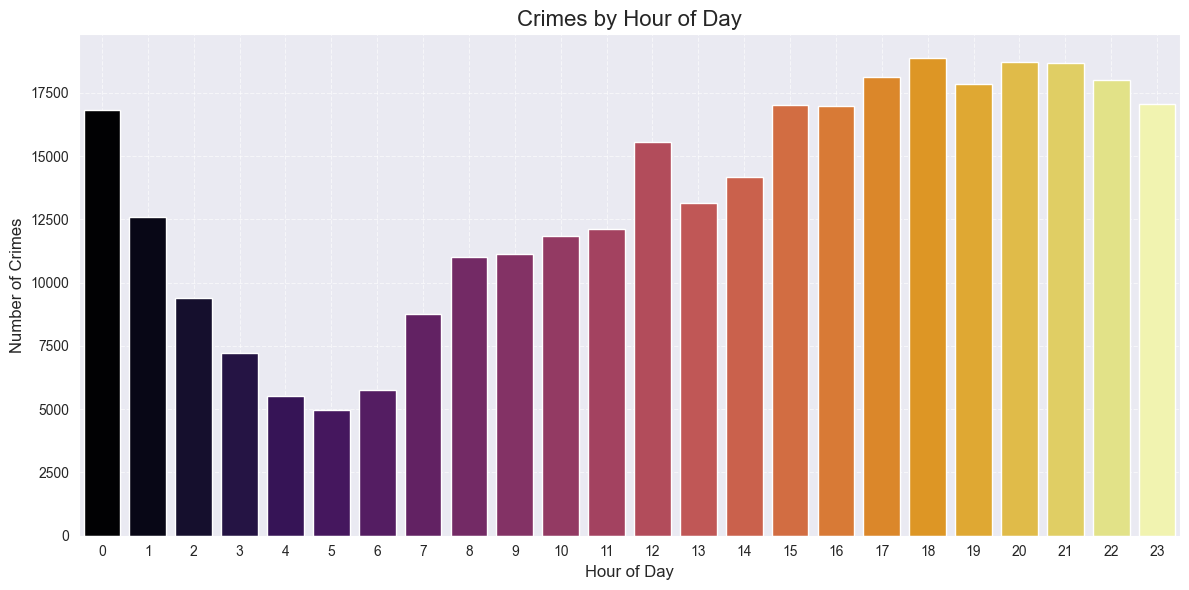

In [18]:
# Crimes by Hour of Day
crime_by_hour = df_geo['CrimeHour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.barplot(x=crime_by_hour.index.astype(int), y=crime_by_hour.values, 
            hue=crime_by_hour.index, palette='inferno', width = .8, dodge = False)
plt.legend([],frameon = False)
plt.title('Crimes by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

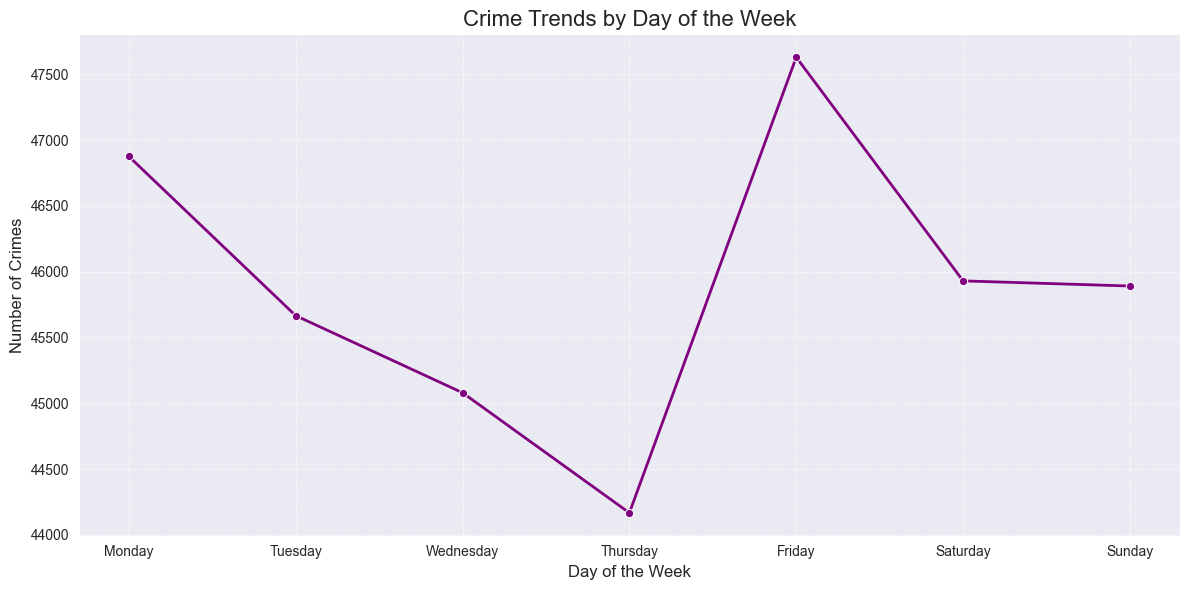

In [19]:
# Count crimes per day
crime_by_day = df_geo['CrimeDay'].value_counts().sort_index()

days_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
sns.lineplot(x=days_labels, y=crime_by_day.values, marker='o', color='purple', linewidth=2)

plt.title('Crime Trends by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)

plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

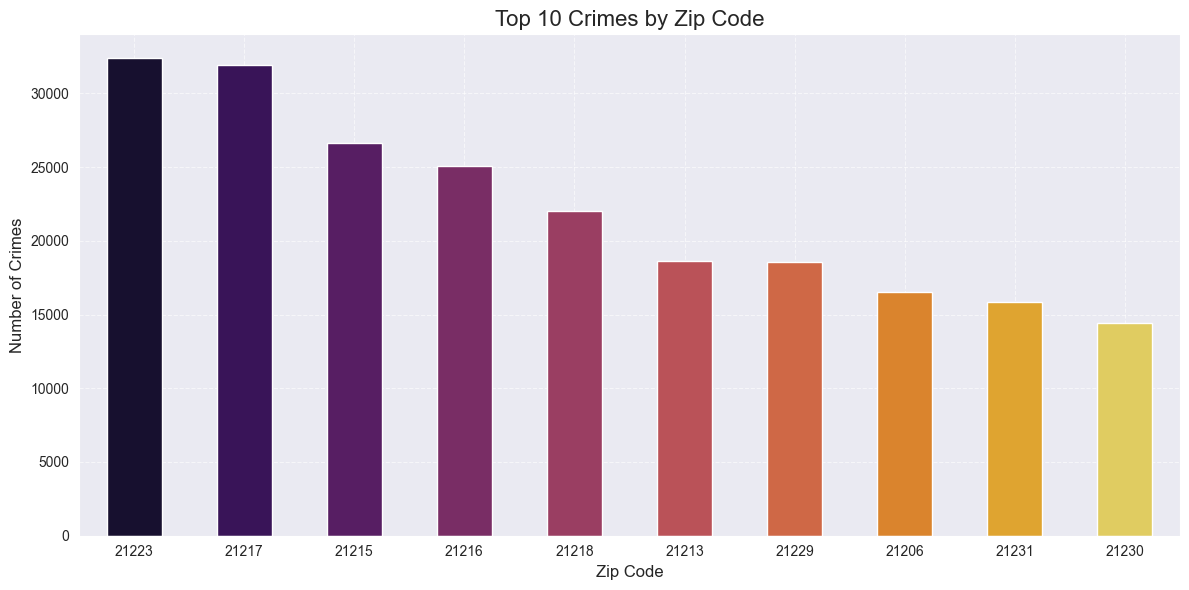

In [20]:
# Crimes by Zip Code
crime_by_zip = df_geo['zip'].value_counts().nlargest(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=crime_by_zip.index.astype(str),
            y=crime_by_zip.values,
            hue=crime_by_zip.index.astype(str),
            palette='inferno', width = .5, dodge = False)
plt.legend([],frameon = False)
plt.title('Top 10 Crimes by Zip Code', fontsize=16)
plt.xlabel('Zip Code', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

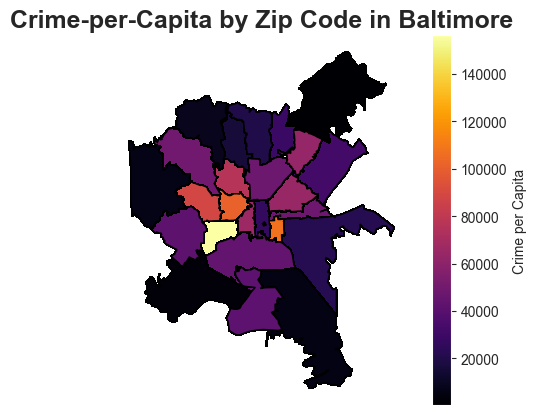

In [21]:
#Crime-per-capita by Zip (Choropleth)

plt.figure(figsize=(12, 8))
df_geo.plot(column='crime_per_capita', cmap='inferno', legend=True,
            edgecolor='black',
            legend_kwds={'label': "Crime per Capita"})

plt.title("Crime-per-Capita by Zip Code in Baltimore", fontsize=18, weight='bold')
plt.axis("off")
plt.show()

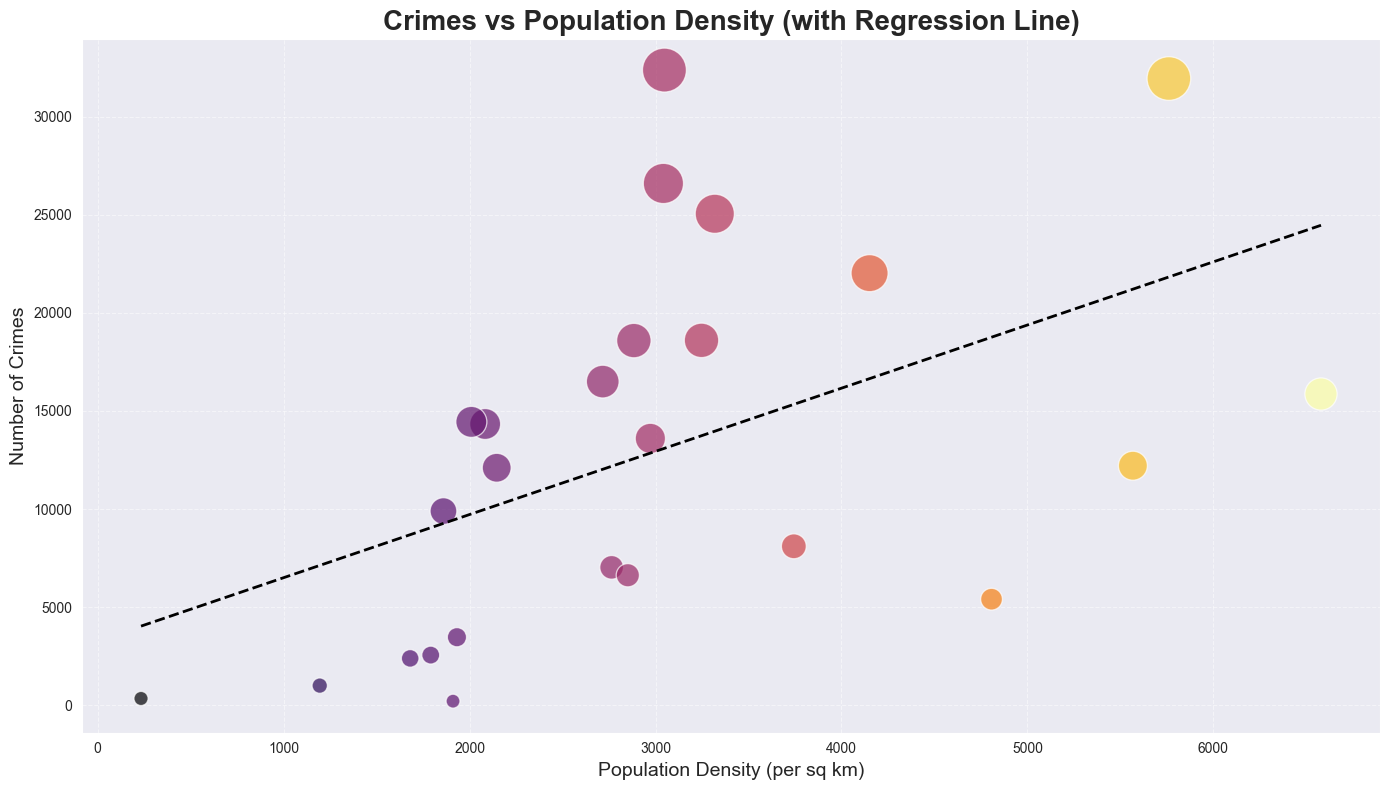

In [22]:
# Step 1: Aggregate data by zip code
zip_density_data = df_geo.groupby('zip').agg({
    'density': 'mean', 
    'RowID': 'count'  
}).reset_index()

zip_density_data.rename(columns={'RowID': 'Crimes', 'density': 'Density'}, inplace=True)

plt.figure(figsize=(14, 8))

scatter = sns.scatterplot(
    data=zip_density_data,
    x='Density',
    y='Crimes',
    hue='Density',
    palette='inferno',
    size='Crimes',
    sizes=(100, 1000),
    alpha=0.7
)

sns.regplot(
    data=zip_density_data,
    x='Density',
    y='Crimes',
    scatter=False,
    color='black',
    line_kws={'linewidth': 2, 'linestyle': '--'},
    ci=None 
)

plt.title('Crimes vs Population Density (with Regression Line)', fontsize=20, fontweight='bold')
plt.xlabel('Population Density (per sq km)', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)

plt.legend([],[],frameon=False)

plt.grid(visible=True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

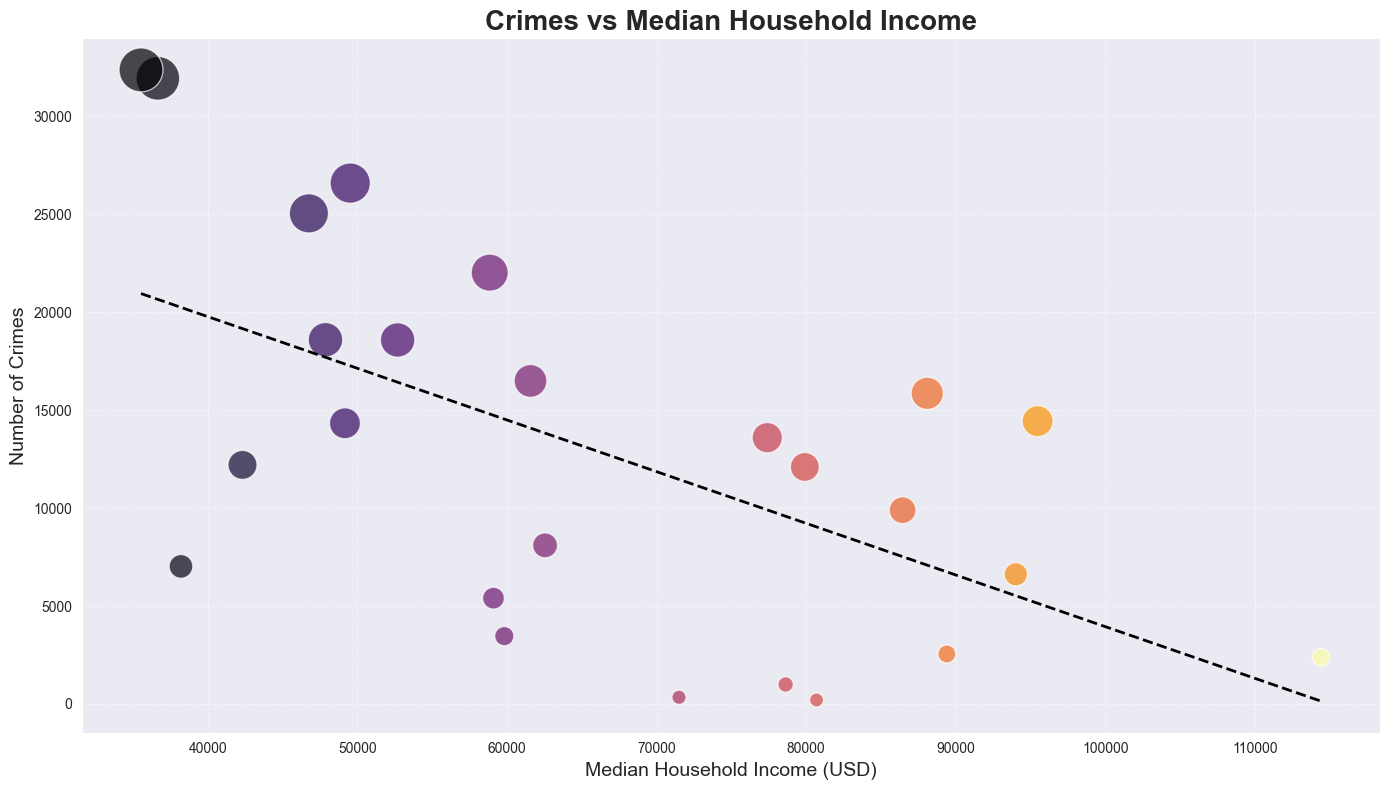

In [23]:
#Crimes by median household income
zip_income_data = df_geo.groupby('zip').agg({
    'income_household_median': 'mean',
    'RowID': 'count'                    
}).reset_index()


zip_income_data.rename(columns={'RowID': 'Crimes', 'income_household_median': 'Median Income'}, inplace=True)

plt.figure(figsize=(14, 8))

scatter = sns.scatterplot(
    data=zip_income_data,
    x='Median Income',
    y='Crimes',
    hue='Median Income',
    palette='inferno',
    size='Crimes',
    sizes=(100, 1000),
    alpha=0.7
)

sns.regplot(
    data=zip_income_data,
    x='Median Income',
    y='Crimes',
    scatter=False,
    color='black',
    line_kws={'linewidth': 2, 'linestyle': '--'},
    ci=None
)

plt.title('Crimes vs Median Household Income', fontsize=20, fontweight='bold')
plt.xlabel('Median Household Income (USD)', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)

plt.legend([],[],frameon=False)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

<Figure size 1200x800 with 0 Axes>

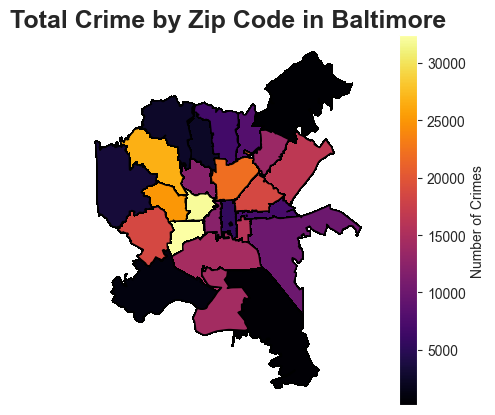

In [19]:
#Crimes by Zip (Choropleth)

plt.figure(figsize=(12, 8))
df_geo.plot(column='crime_count', cmap='inferno', legend=True,
            edgecolor='black',
            legend_kwds={'label': "Number of Crimes"})
plt.title("Total Crime by Zip Code in Baltimore", fontsize=18, weight='bold')
plt.axis("off")
plt.show()

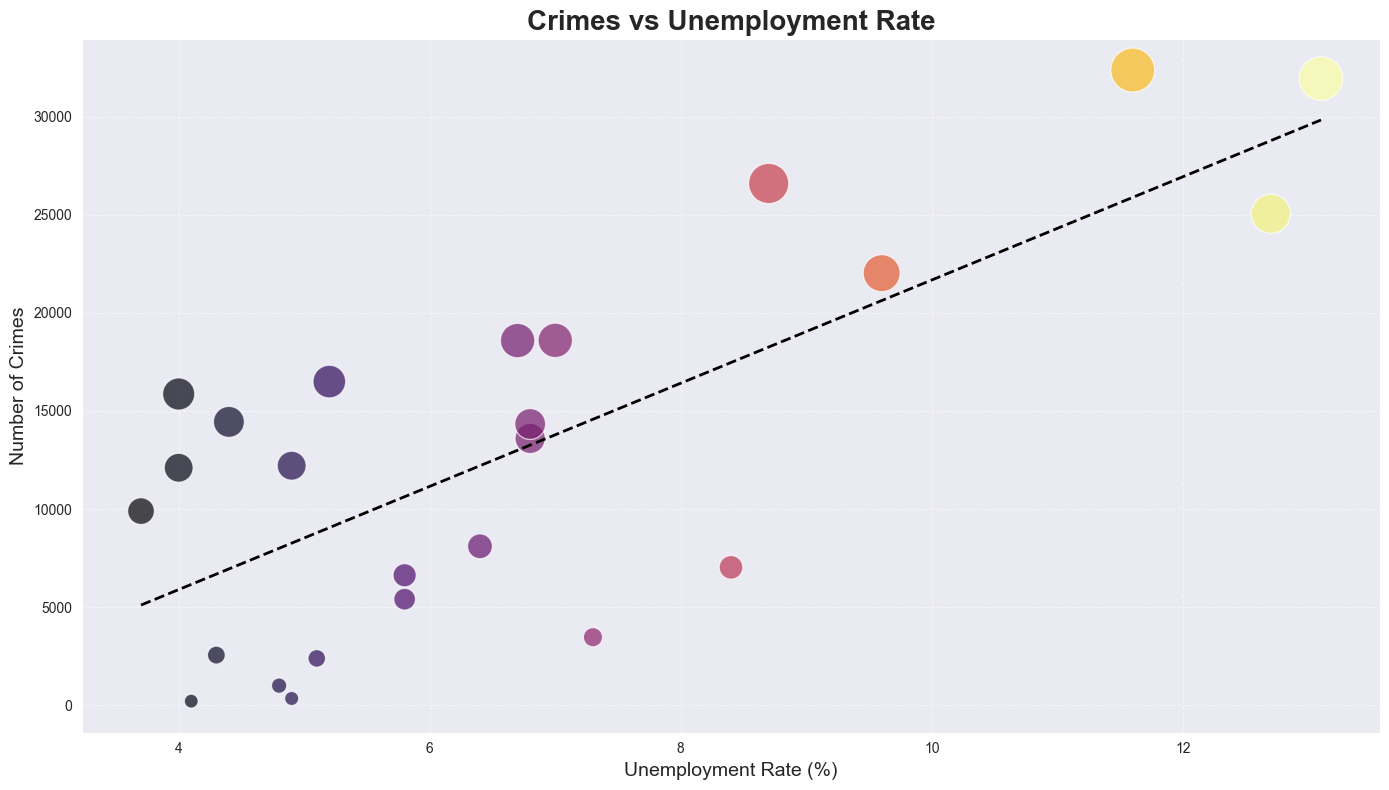

In [24]:
# Crimes by unemployment rates
zip_unemployment_data = df_geo.groupby('zip').agg({
    'unemployment_rate': 'mean',
    'RowID': 'count' 
}).reset_index()

zip_unemployment_data.rename(columns={'RowID': 'Crimes', 'unemployment_rate': 'Unemployment Rate'}, inplace=True)

plt.figure(figsize=(14, 8))

scatter = sns.scatterplot(
    data=zip_unemployment_data,
    x='Unemployment Rate',
    y='Crimes',
    hue='Unemployment Rate',
    palette='inferno',
    size='Crimes',
    sizes=(100, 1000),
    alpha=0.7
)

sns.regplot(
    data=zip_unemployment_data,
    x='Unemployment Rate',
    y='Crimes',
    scatter=False,
    color='black',
    line_kws={'linewidth': 2, 'linestyle': '--'},
    ci=None
)

plt.title('Crimes vs Unemployment Rate', fontsize=20, fontweight='bold')
plt.xlabel('Unemployment Rate (%)', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)

plt.legend([], [], frameon=False)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()


plt.show()

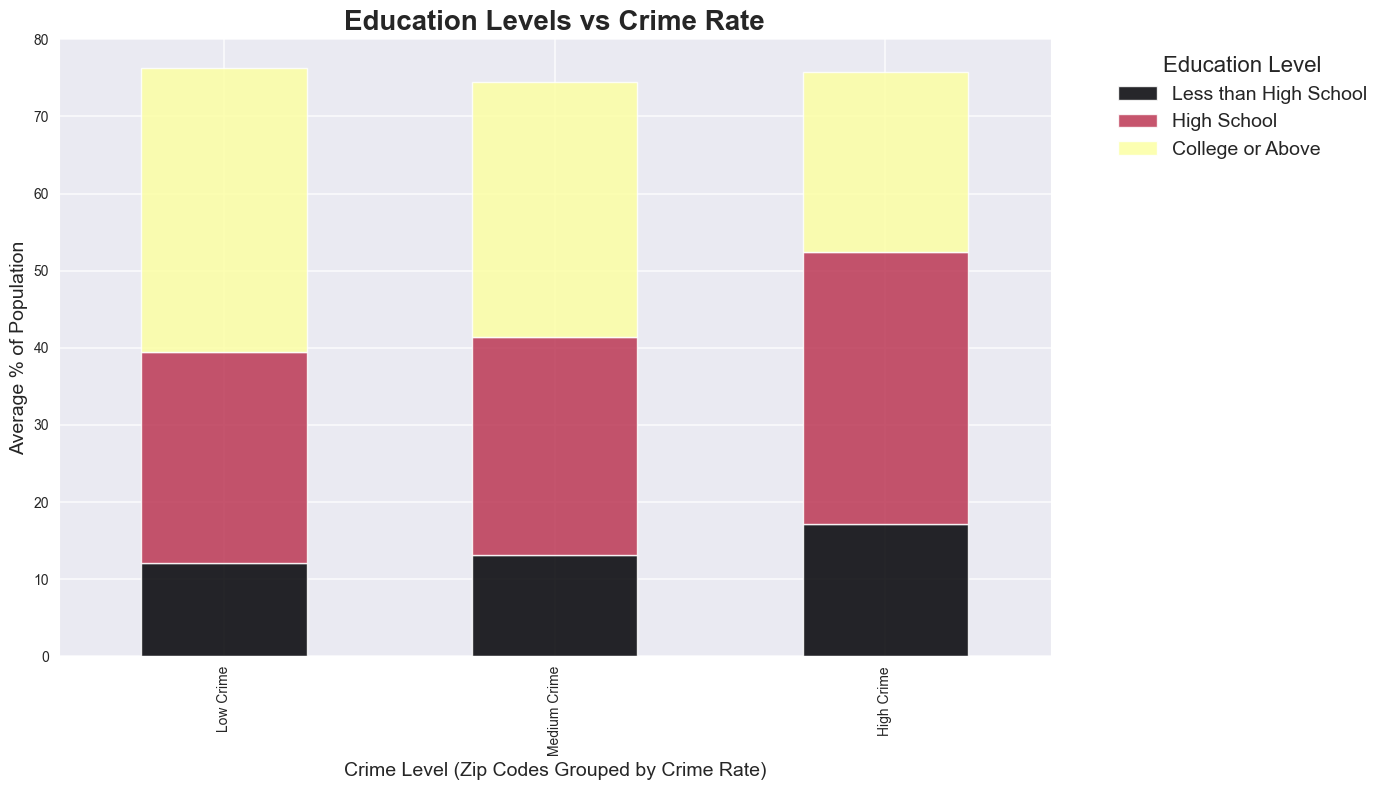

In [25]:
#Crimes by Education Level
edu_cols = ['education_less_highschool', 'education_highschool', 'education_college_or_above']

edu_crime_data = df_geo.groupby(pd.qcut(df_geo['crime_per_capita'], 3, labels=["Low Crime", "Medium Crime", "High Crime"]), observed = False)[edu_cols].mean()


plt.figure(figsize=(14, 8))

edu_crime_data.plot(kind='bar', stacked=True, colormap='inferno', alpha=0.85, ax=plt.gca())

plt.title('Education Levels vs Crime Rate', fontsize=20, fontweight='bold')
plt.xlabel('Crime Level (Zip Codes Grouped by Crime Rate)', fontsize=14)
plt.ylabel('Average % of Population', fontsize=14)

plt.legend(
    title="Education Level",
    labels=["Less than High School", "High School", "College or Above"],
    title_fontsize= 16,
    fontsize= 14,
    frameon=False,
    bbox_to_anchor=(1.05, 1), loc='upper left'
)

plt.grid(visible=True, linestyle='-', linewidth = 1.2, alpha=0.8)
plt.tight_layout()

plt.show()

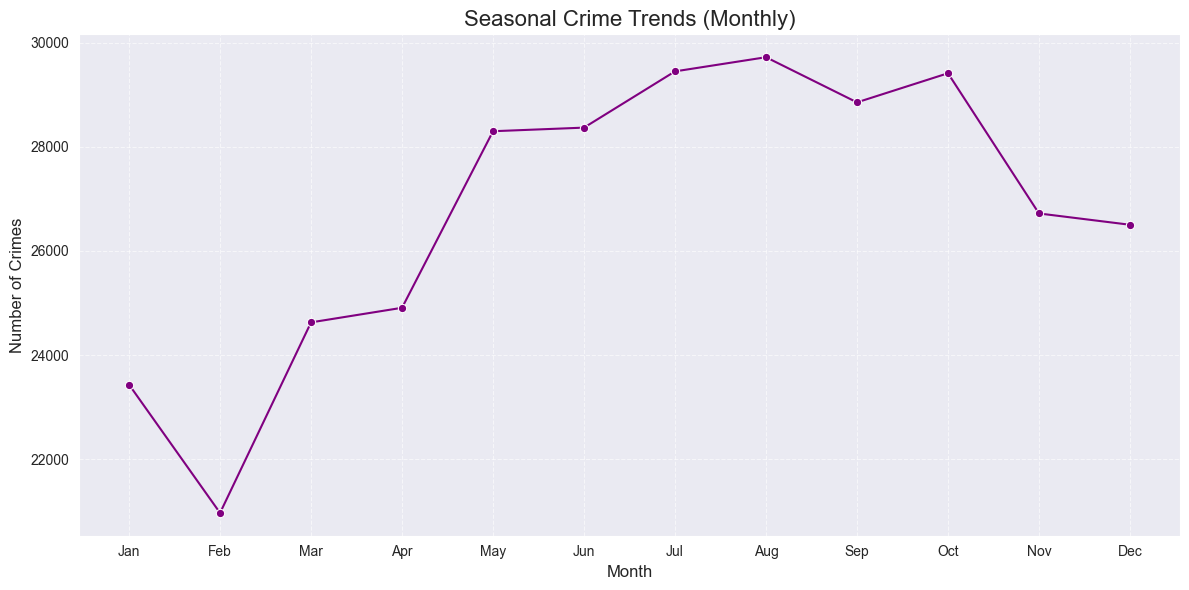

In [26]:
# Seasonal Crime Trends (Monthly)
crime_by_month = df_geo['CrimeMonth'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=crime_by_month.index, y=crime_by_month.values, marker='o', color='purple')
plt.title('Seasonal Crime Trends (Monthly)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

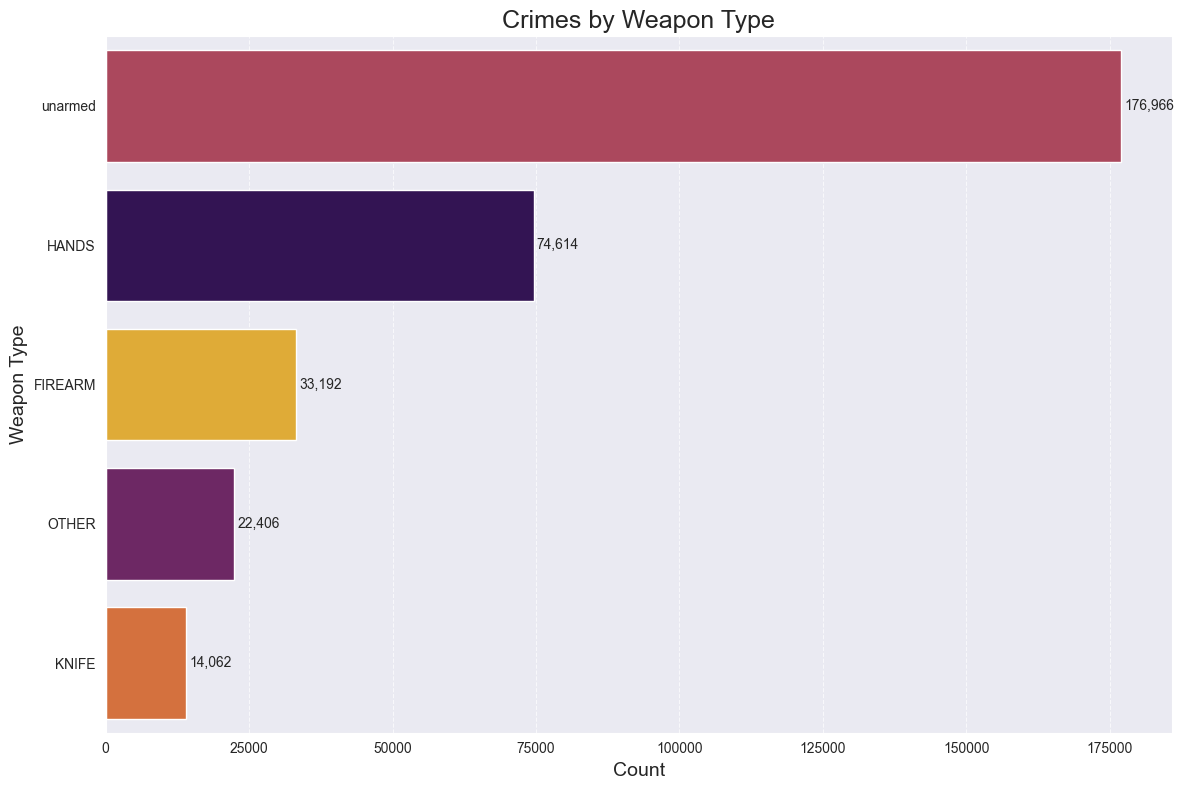

In [27]:
# Plot count of crimes by weapon type
plt.figure(figsize=(12, 8))
sns.countplot(
    data=df_geo,
    y='WEAPON',
    order=df_geo['WEAPON'].value_counts().index,
    hue='WEAPON', 
    palette='inferno',
    dodge=False
)
plt.legend([],frameon = False)
plt.title('Crimes by Weapon Type', fontsize=18)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Weapon Type', fontsize=14)

weapon_counts = df_geo['WEAPON'].value_counts()
for index, value in enumerate(weapon_counts):
    plt.text(value + 500, index, f'{value:,}', va='center', fontsize=10)

plt.tight_layout()
plt.grid(axis='x', visible=True, linestyle='--', alpha=0.7)
plt.show()

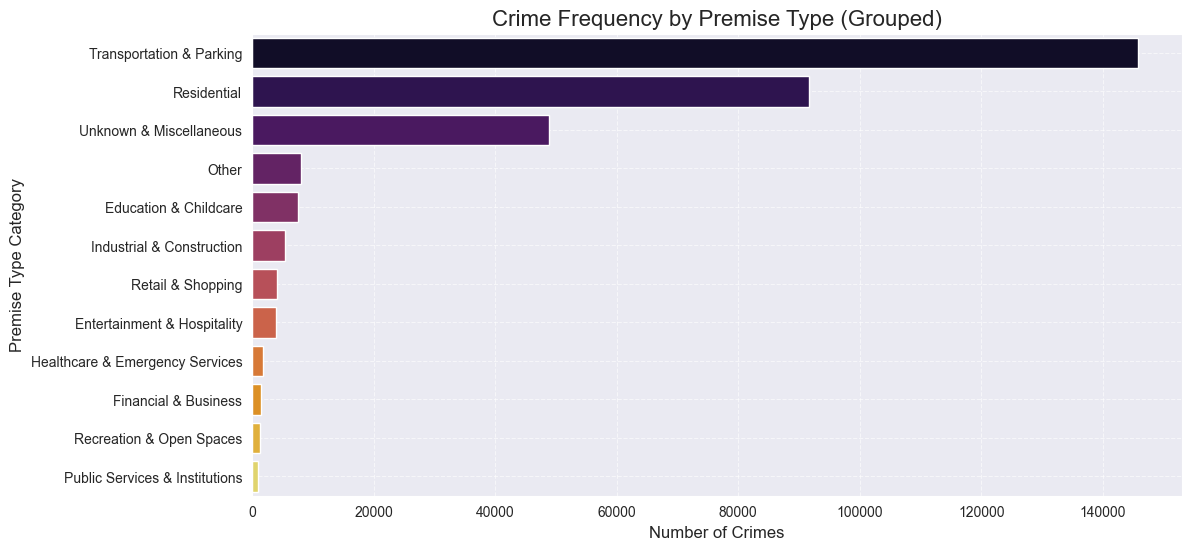

In [28]:
#Plotting crime by premise type (binned w/our dictionary)
premise_counts = df_geo['PremiseType_Grouped'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(y=premise_counts.index,
            x=premise_counts.values,
            hue =premise_counts.index,
            palette='inferno', dodge = False, width = .8)
plt.legend([],frameon = False)
plt.title('Crime Frequency by Premise Type (Grouped)', fontsize=16)
plt.xlabel('Number of Crimes', fontsize=12)
plt.ylabel('Premise Type Category', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

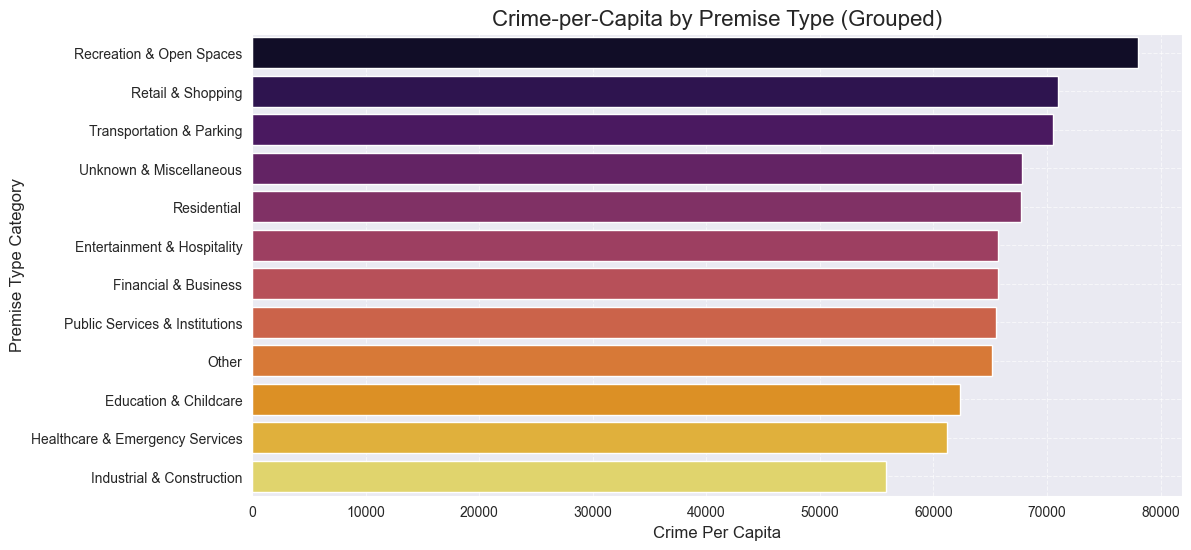

In [29]:
#Similar graph as above, but this time graphing average crime-per-capita to premise type
premise_per_capita = df_geo.groupby("PremiseType_Grouped")["crime_per_capita"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=premise_per_capita.index,
            x=premise_per_capita.values,
            hue =premise_per_capita.index,
            palette='inferno', dodge=False, width=0.8)

plt.title('Crime-per-Capita by Premise Type (Grouped)', fontsize=16)
plt.xlabel('Crime Per Capita', fontsize=12)
plt.ylabel('Premise Type Category', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.show()

At first glance, these two graphs seem to tell opposing stories. However let's think about it. In the first graph, Transportation & Parking had the highest *total* crime. However, it isn't the highest on the per-capita graph. This could be due to the fact that Transportation & Parking areas typically have many more people in a closer setting (i.e., streets and subways), and these are typically in inner-city areas. Conversely, while 'Recreation & Open Spaces' had little *total* crime, it is the highest in the per-capita graph. This makes sense again, as there are fewer people living in 'Open spaces.' So, even very few overall crimes have an inflated per-capita value when very few people live there. 

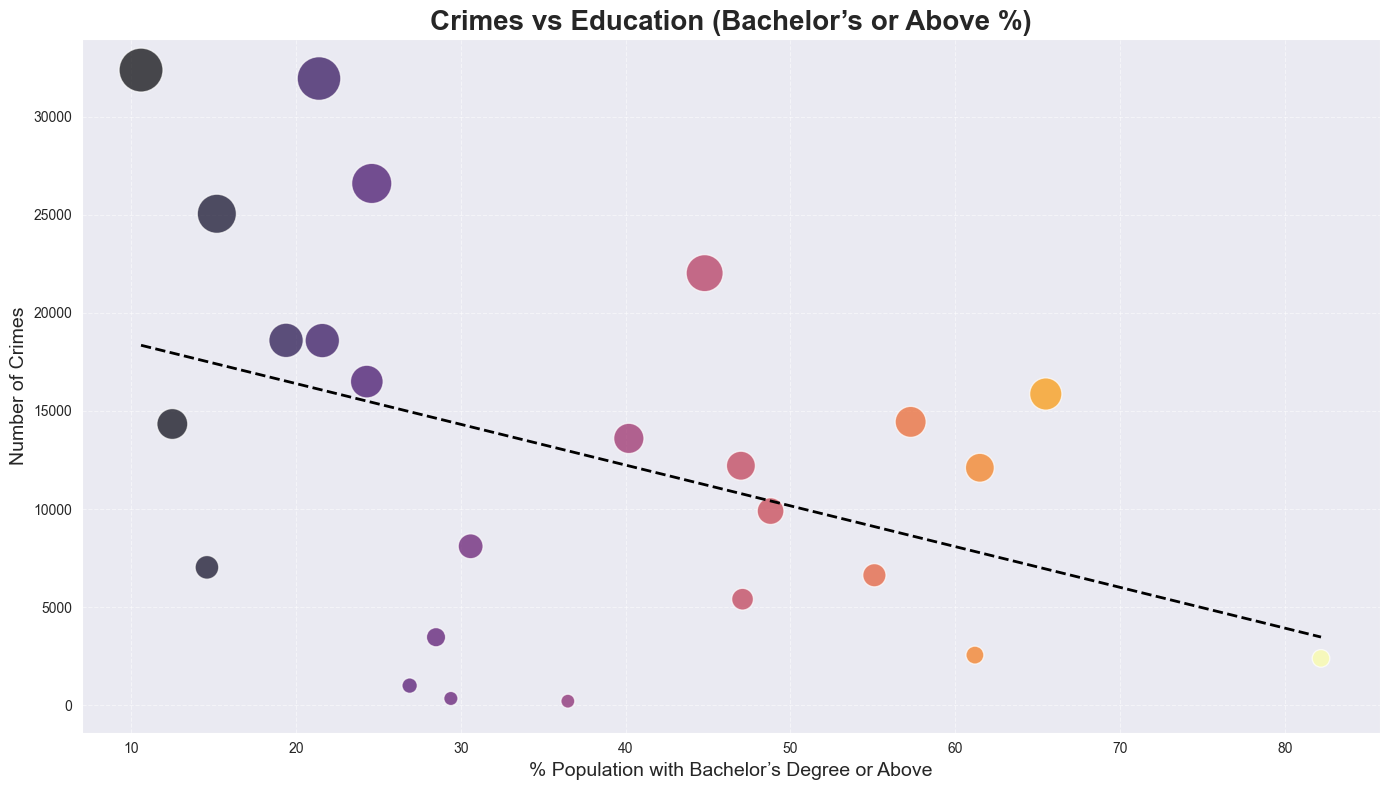

In [30]:
# Create `socioeconomic_data` with aggregated values
socioeconomic_data = df_geo.groupby('zip').agg({
    'education_college_or_above': 'mean',  # Aggregated education data
    'RowID': 'count'  # Counting crimes per ZIP
}).reset_index()

# Rename columns for easier access (avoid special characters)
socioeconomic_data.rename(columns={'education_college_or_above': 'Education_Bachelors', 'RowID': 'Crimes'}, inplace=True)

# Scatterplot of education level vs number of crimes
plt.figure(figsize=(14, 8))

# Scatterplot with enhanced aesthetics
scatter = sns.scatterplot(
    data=socioeconomic_data,
    x='Education_Bachelors',
    y='Crimes',
    hue='Education_Bachelors',
    palette='inferno',
    size='Crimes',
    sizes=(100, 1000),
    alpha=0.7
)

# Regression line (correct dataset)
sns.regplot(
    data=socioeconomic_data,
    x='Education_Bachelors',
    y='Crimes',
    scatter=False,
    color='black',
    line_kws={'linewidth': 2, 'linestyle': '--'},
    ci=None
)

# Titles and labels
plt.title('Crimes vs Education (Bachelor’s or Above %)', fontsize=20, fontweight='bold')
plt.xlabel('% Population with Bachelor’s Degree or Above', fontsize=14)
plt.ylabel('Number of Crimes', fontsize=14)

# Remove legend
plt.legend([], [], frameon=False)

# Gridlines for better readability
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Ensure layout is properly adjusted
plt.tight_layout()

# Show the plot
plt.show()

<Figure size 1400x700 with 0 Axes>

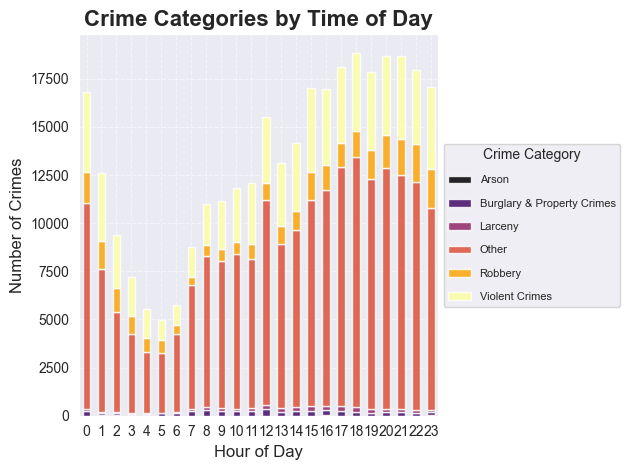

In [31]:
#Crime Categories by Time of Day #1
df_geo['CrimeHour'] = pd.to_datetime(df_geo['CrimeDateTime']).dt.hour

crime_by_hour_category = df_geo.groupby(['CrimeHour', 'CrimeCategory']).size().unstack()

# Plot
plt.figure(figsize=(14, 7))
crime_by_hour_category.plot(kind='bar', stacked=True, colormap='inferno', alpha=0.85)

plt.title('Crime Categories by Time of Day', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[str(i) for i in range(0, 24)], rotation=0)

plt.legend(
    title='Crime Category',
    title_fontsize= 10,
    fontsize=8,
    loc='center left',
    bbox_to_anchor=(1, 0.5), 
    frameon=True, 
    labelspacing=1.2
)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


That is pretty hard to read - let's try again after dropping the 'other category' for now

<Figure size 1400x700 with 0 Axes>

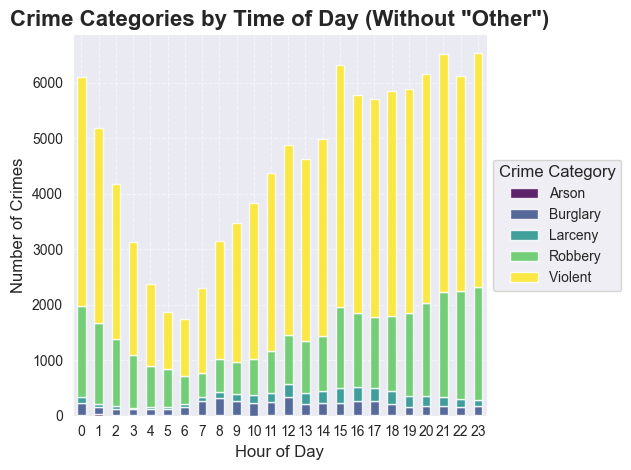

In [32]:
#Crime Categories by Time of Day #2
filtered_df = filter_crime_data(df_geo, exclude_categories=['Other'])

crime_by_hour_category = filtered_df.groupby(['CrimeHour', 'CrimeCategory']).size().unstack()

plt.figure(figsize=(14, 7))
ax = crime_by_hour_category.plot(kind='bar', stacked=True, colormap='viridis', alpha=0.85)

plt.title('Crime Categories by Time of Day (Without "Other")', fontsize=16, fontweight='bold')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[str(i) for i in range(0, 24)], rotation=0)


handles, labels = ax.get_legend_handles_labels()
short_labels = [label.replace('Crimes', '').replace('Sexual', 'Sex').replace(' & Property', '').replace('Motor', '') for label in labels]

plt.legend(
    handles=handles,
    labels=short_labels,
    title='Crime Category',
    title_fontsize=12,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Up next want to do basically the same thing, but month-to-month to see if there's any standout differences seasonally

<Figure size 1400x700 with 0 Axes>

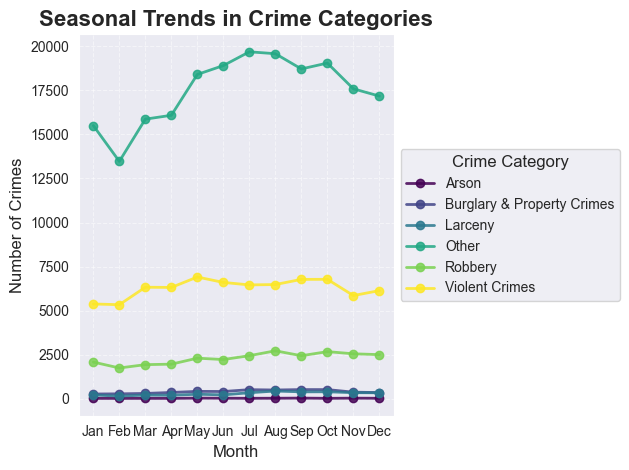

In [33]:
#Crime trends over month
crime_by_month_category = df_geo.groupby(['CrimeMonth', 'CrimeCategory']).size().unstack()


plt.figure(figsize=(14, 7))

ax = crime_by_month_category.plot(kind='line', marker='o', colormap='viridis', linewidth=2, alpha=0.85)

plt.title('Seasonal Trends in Crime Categories', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


plt.legend(
    title='Crime Category',
    title_fontsize=12,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)


plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

Similar to before, unfortunately the 'unknown' value overwhelms the rest of the graph. Let's look at it again without that bin. 

<Figure size 1400x700 with 0 Axes>

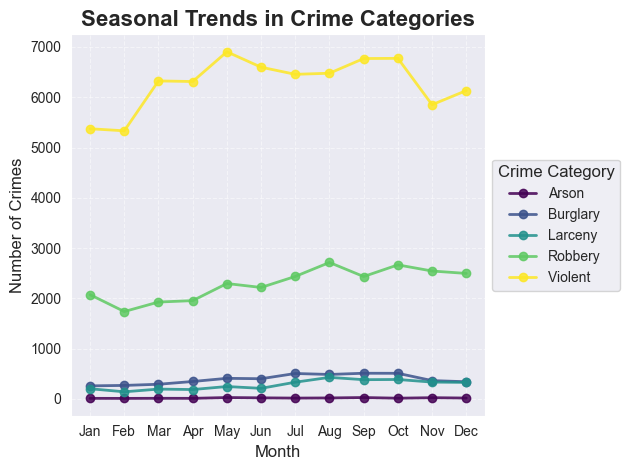

In [34]:
#Crime Trends by month #2
crime_by_month_category = filtered_df.groupby(['CrimeMonth', 'CrimeCategory']).size().unstack()


plt.figure(figsize=(14, 7))

ax = crime_by_month_category.plot(kind='line', marker='o', colormap='viridis', linewidth=2, alpha=0.85)

plt.title('Seasonal Trends in Crime Categories', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

handles, labels = ax.get_legend_handles_labels()
short_labels = [label.replace('Crimes', '').replace('Sexual', 'Sex').replace(' & Property', '').replace('Motor', '') for label in labels]

plt.legend(
    handles=handles,
    labels=short_labels,
    title='Crime Category',
    title_fontsize=12,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)


plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

Let's try one more time - just looking at violent crime and robbery

<Figure size 1400x700 with 0 Axes>

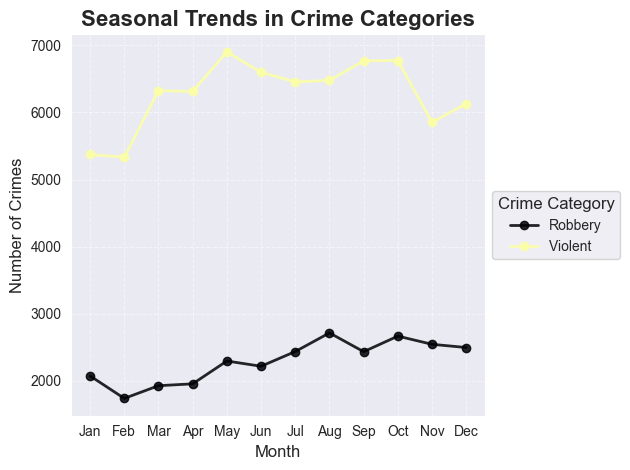

In [35]:
#Crime Trends by month #3

filtered_df = filter_crime_data(df_geo, exclude_categories=['Other', 'Arson', 'Motor Vehicle Theft', 'Larceny', 'Burglary & Property Crimes', 'Sexual Crimes'])

crime_by_month_category = filtered_df.groupby(['CrimeMonth', 'CrimeCategory']).size().unstack()

plt.figure(figsize=(14, 7))

ax = crime_by_month_category.plot(kind='line', marker='o', colormap='inferno', linewidth=2, alpha=0.85)


plt.title('Seasonal Trends in Crime Categories', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

handles, labels = ax.get_legend_handles_labels()
short_labels = [label.replace('Crimes', '') for label in labels]

plt.legend(
    handles=handles,
    labels=short_labels,
    title='Crime Category',
    title_fontsize=12,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

And actually, let's do this one more time w/the opposite columns and see if anything stands out there

<Figure size 1400x700 with 0 Axes>

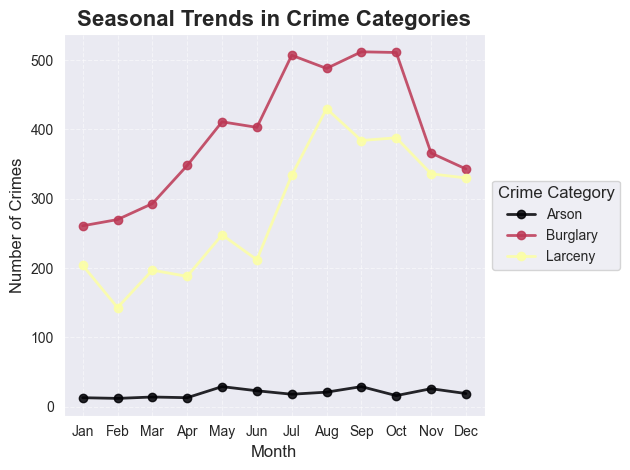

In [36]:
#Crime trends by month #4

#new filter for removing a couple more bins
filtered_df = filter_crime_data(df_geo, exclude_categories=['Violent Crimes', 'Robbery', 'Other'])

crime_by_month_category = filtered_df.groupby(['CrimeMonth', 'CrimeCategory']).size().unstack()

plt.figure(figsize=(14, 7))

ax = crime_by_month_category.plot(kind='line', marker='o', colormap='inferno', linewidth=2, alpha=0.85)

plt.title('Seasonal Trends in Crime Categories', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Crimes', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

handles, labels = ax.get_legend_handles_labels()
short_labels = [label.replace('Crimes', '').replace('& Property', '') for label in labels]

plt.legend(
    handles=handles,
    labels=short_labels,
    title='Crime Category',
    title_fontsize=12,
    fontsize=10,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=True
)

plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()

MAKING A BIG SPACE TO MAKE IT CLEAR WE ARE MOVING FROM EDA TO VISUALIZATION FOR NOW

JUST TO KEEP IT CLEAR BETWEEN TEAM MEMBERS

THIS SPACE SHOULD BE REMOVED BEFORE WE TURN IN OUR CODEEEEEEEEEEEEEEEE
















ANDDDDDDD END

And now we will start to move into some Analysis / Visualization of our specific research questions

Research Question 1: Crime Hotspots and Socioeconomic Patterns: Where are crime hotspots in Baltimore, and how do these hotspots correlate with socioeconomic factors (e.g., household income, unemployment rates, and education levels)? Additionally, do these patterns vary seasonally or by time of day?

First up - some correlation statistics. We have an idea of what is related from our EDA, but that was all visual (not statistical / significant)

In [37]:
#First for this, we'll have to aggregate by zipcode 

zip_crime_data = df_geo.groupby('zip').agg({
    'RowID': 'count',  # Total number of crimes per ZIP
    'crime_per_capita': 'mean',  # Average crime per capita per ZIP
    'income_household_median': 'mean',
    'unemployment_rate': 'mean',
    'education_less_highschool': 'mean',
    'education_highschool': 'mean',
    'education_college_or_above': 'mean',
    'poverty': 'mean',
    'density': 'mean'
}).reset_index()

#a quick re-name
zip_crime_data.rename(columns={'RowID': 'crime_count'}, inplace=True)

#print(zip_crime_data.head())

Now we have one row per zipcode and can do a correlation matrix across zipcodes

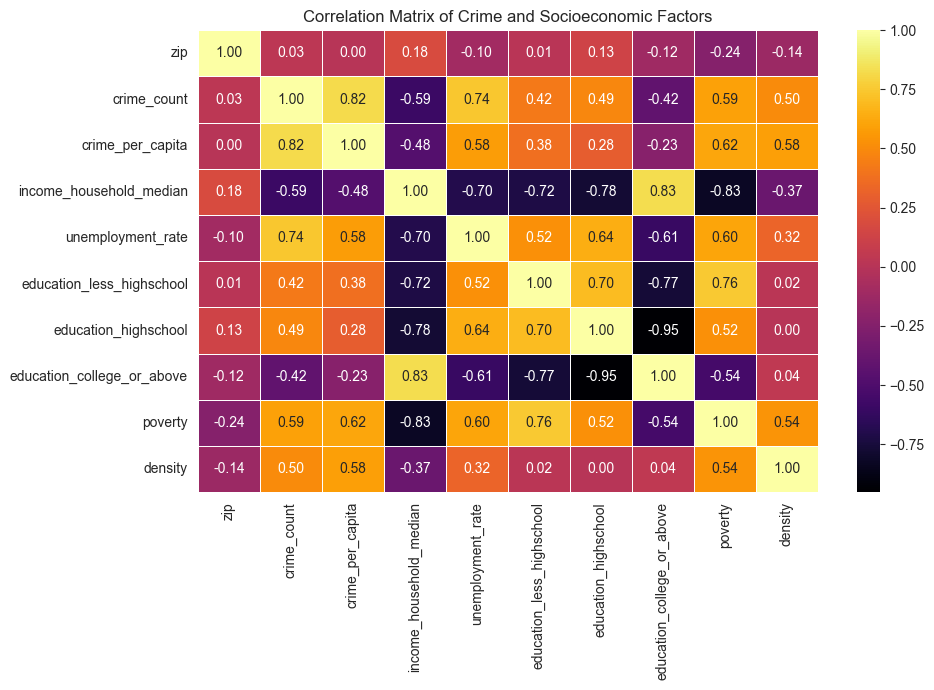

In [38]:
#pearson's correlation
plt.figure(figsize=(10, 6))
sns.heatmap(zip_crime_data.corr(), annot=True, cmap='inferno', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Crime and Socioeconomic Factors')
plt.show()

Some stand out values for crime_per_capita:
crime_per_capita & income_househole_median = -.48
crime_per_capita & unemployment_rate = 0.58
crime_per_capita & education_less_highschool = 0.38 
                 & education_highschool = 0.28
                 & education_college_or_above = -0.23
crime_per_capita & poverty = 0.62
crime_per_capita & density = 0.58


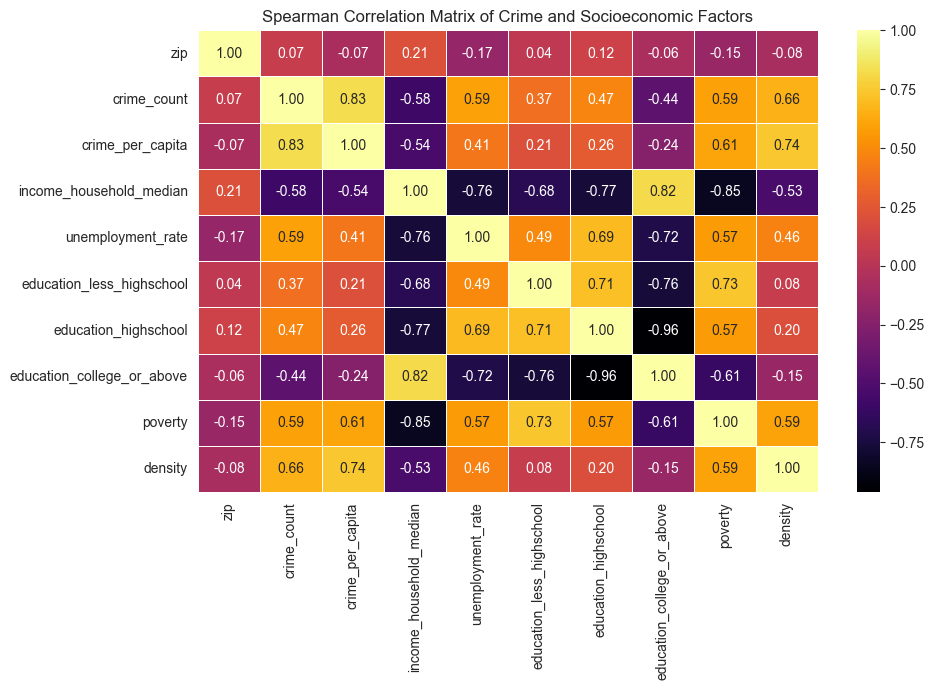

In [39]:
#spearman's correlation
plt.figure(figsize=(10, 6))
sns.heatmap(zip_crime_data.corr(method='spearman'), annot=True, cmap='inferno', fmt=".2f", linewidths=0.5)
plt.title('Spearman Correlation Matrix of Crime and Socioeconomic Factors')
plt.show()

Some stand out values:
crime_per_capita & income_househole_median = -.54
crime_per_capita & unemployment_rate = 0.41
crime_per_capita & education_less_highschool = 0.21
                 & education_highschool = 0.26
                 & education_college_or_above = -0.24
crime_per_capita & poverty = 0.61
crime_per_capita & density = 0.74


Generally, Pearson's R is better for linear relationships that are normally distributed, whereas Spearman's is better for non-linear relationships. 
They both have very similar values, but for our data, I would give more weight to Pearson's R, as these are continuous variables that seem relatively linear based on our previous scatterplots. 

In general:
0.7 - 0.9 indicates a `Strong Positive`
0.4 - 0.6 indicates a `Moderate Positive`
0.1 - 0.3 indicates a `Weak positive` 
(and then opposite for negatives).

Using these values from our Pearson's correlation, we had:


3 moderate positives:
crime_per_capita & poverty = 0.62
crime_per_capita & density = 0.58
crime_per_capita & unemployment_rate = 0.58

2 weak positives:
crime_per_capita & education_less_highschool = 0.38 
crime_per_capita& education_highschool = 0.28

1 moderate negatives:
crime_per_capita & income_househole_median = -.48

1 weak negative:
crime_per_capita & education_college_or_above = -0.23

Now that we have a list of things to test, we can do some significance testing. We'll continue using 'crime_per_capita' to give a more standardized view across the city.

In [40]:
variables_to_test = [
    'unemployment_rate', 'education_less_highschool', 'education_highschool',
    'poverty', 'density', 'income_household_median', 'education_college_or_above'
]

correlation_results = {}

for var in variables_to_test:
    r, p = pearsonr(df_geo['crime_per_capita'], df_geo[var])
    correlation_results[var] = {'r_value': r, 'p_value': p}

corr_df = pd.DataFrame.from_dict(correlation_results, orient='index')
print(corr_df.sort_values(by="r_value", key=abs, ascending=False))

                             r_value  p_value
poverty                     0.636009      0.0
unemployment_rate           0.589637      0.0
education_less_highschool   0.533084      0.0
income_household_median    -0.475690      0.0
density                     0.378016      0.0
education_college_or_above -0.341229      0.0
education_highschool        0.318962      0.0


Since the p_value is showing as '0.0' that means it's really just <0.001 (so, highly significant). 
Our strongest correlation is crime_count vs. poverty. 
The strongest negative correlation is crime_count to income_median_household. 


Up next we'll take this information and do some regression analysis. 

In [41]:
#OLS Regression

X = df_geo[['poverty', 'unemployment_rate', 'education_less_highschool',
            'education_highschool', 'education_college_or_above',
            'income_household_median', 'density']]
Y = df_geo['crime_per_capita']

X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       crime_per_capita   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.561
Method:                 Least Squares   F-statistic:                 5.857e+04
Date:                Sat, 15 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:01:31   Log-Likelihood:            -3.7201e+06
No. Observations:              321240   AIC:                         7.440e+06
Df Residuals:                  321232   BIC:                         7.440e+06
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

The R^2 value of 0.561 indicates that 56.1% crime_per_capita is explained by these 7 soceioeconimic variables. The F-statistic of 5.89*10^4 and p-value of 0.00 (so, <0.001) indicates this is highly significant.

Then under the coefficient numbers we can interpret a few of these results:
a 1% increase in `poverty` results in ~1337 crimes per 100k people. 
a 1% increase in `unemployment` results in ~5290 crimes per 100k people. 
a $1 increase in `income_household_median` results in slightly lower crime per capita. 

Looking at this, unemployment is the single biggest factor. Though, it could be argued that unemployment, poverty, and household_median_income are all related. 

##START OF CHAVON'S CODES -----------------------------------------------------------------------------------------------

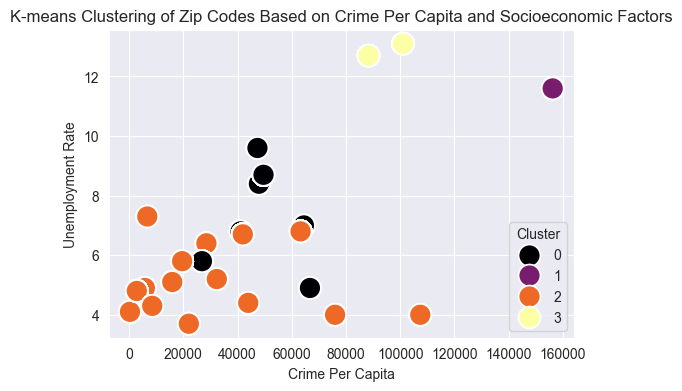

In [42]:
#K-Means Zip Clustering by Crime Per Capita, Poverty, Unemployment Rate, and Education Less High School

#Group
columns = ['crime_per_capita', 'poverty', 'unemployment_rate', 'education_less_highschool']

scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_geo[columns])

kmeans = KMeans(n_clusters = 4, random_state = 50)
df_geo['cluster'] = kmeans.fit_predict(scaled_feat)

#Plot
plt.figure(figsize = (6,4))
sns.scatterplot(x=df_geo['crime_per_capita'], y=df_geo['unemployment_rate'], hue = df_geo['cluster'], palette = 'inferno', s=250)
plt.title('K-means Clustering of Zip Codes Based on Crime Per Capita and Socioeconomic Factors')
plt.xlabel('Crime Per Capita')
plt.ylabel('Unemployment Rate')
plt.legend(loc = 'lower right', title = 'Cluster')
plt.show()


In [43]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
df_clusters = pd.DataFrame(cluster_centers, columns=columns)
df_clusters['Cluster'] = range(4)
print(df_clusters)

   crime_per_capita    poverty  unemployment_rate  education_less_highschool  \
0      51279.361145  25.084982           7.728189                  14.958663   
1     156233.114628  32.900000          11.600000                  25.600000   
2      48523.707128  13.551260           5.258840                   9.657411   
3      95435.772430  26.395965          12.924193                  15.446369   

   Cluster  
0        0  
1        1  
2        2  
3        3  


This K-means cluster analysis allows us to visualize the zip codes grouped based on unemployment rate, poverty, education level less than high school, and crime per capita. We've created 4 cluster groups in which the zip codes could belong to. Two of the cluster groups make up the majority of the zip codes which have lower crime rates and lower unemployment rates (Clusters 0 and 2). These clusters have the lowest crime_per_capita number, as well as the lowest rating in all 3 other variables (povery / unemployment rate / education less highschool). The other two cluster groups have higher crime per capita and higher unemployment rates. 

Up next we will begin our ANOVA testing

In [44]:
#ANOVA - CrimeCategory
CrimeCategory_model = ols('crime_per_capita ~ C(CrimeCategory)', data = df_geo).fit()
anova_CrimeCategory = anova_lm(CrimeCategory_model)
print(anova_CrimeCategory)

                        df        sum_sq       mean_sq         F        PR(>F)
C(CrimeCategory)       5.0  3.006448e+11  6.012896e+10  39.44988  1.133751e-40
Residual          321234.0  4.896204e+14  1.524186e+09       NaN           NaN


The Crime Category Anova test resulted in a high F-statistic of ~39.45, indicating there is a large difference within the crime categories. The low p-value of 1.420420e-40 indicates the crime per capita is different accross all zip codes and is statistically significant. This could also give insight that certain crime types may need extra focus or prevention measures. 

In [45]:
#We can do a post-hoc test to see exactly where the difference is: 
tukey = pairwise_tukeyhsd(df_geo['crime_per_capita'], df_geo['CrimeCategory'])
print(tukey)

                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                         
          group1                     group2            meandiff  p-adj     lower      upper    reject
-----------------------------------------------------------------------------------------------------
                     Arson Burglary & Property Crimes -8415.9307 0.0166 -15882.4697  -949.3917   True
                     Arson                    Larceny -3156.5045   0.84 -10691.0812  4378.0722  False
                     Arson                      Other -6108.2041 0.1607 -13400.7925  1184.3843  False
                     Arson                    Robbery -4138.3648 0.5911 -11457.7165  3180.9869  False
                     Arson             Violent Crimes -4312.1477 0.5428 -11611.9617  2987.6662  False
Burglary & Property Crimes                    Larceny  5259.4262    0.0   2754.7914   7764.061   True
Burglary & Property Crimes                      Other  2307.7266 0.0008    669.070

This let's us see where the significant differences are: 
Burglary & Property Crimes are significantly more common than any other crime 'bin' that we created. 
Arson is committed significantly less  than Property Crimes, and Larceny is committed significantly less than 'Other' crimes.  

In [46]:
#ANOVA - PremiseType
PremiseType_model = ols('crime_per_capita ~ C(PremiseType_Grouped)', data = df_geo).fit()
anova_PremiseType = anova_lm(PremiseType_model)
print(anova_PremiseType)

                              df        sum_sq       mean_sq           F  \
C(PremiseType_Grouped)      11.0  2.220902e+12  2.019002e+11  132.983338   
Residual                321228.0  4.877001e+14  1.518237e+09         NaN   

                               PR(>F)  
C(PremiseType_Grouped)  1.730397e-306  
Residual                          NaN  


The Premise Type ANOVA test also resulted in a high F-statistic value of 132.92, meaning there is significant difference within the premise types. This test also produced a low p-value of ~0.0 showing it is statistically significant. This indicates certain locations may require extra patroling to prevent crimes.

In [48]:
tukey = pairwise_tukeyhsd(df_geo['crime_per_capita'], df_geo['PremiseType_Grouped'])
print(tukey)

                              Multiple Comparison of Means - Tukey HSD, FWER=0.05                               
             group1                          group2               meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------------------------------------------------
          Education & Childcare     Entertainment & Hospitality    3345.255 0.0007    851.6788  5838.8312   True
          Education & Childcare            Financial & Business   3340.0238 0.0886   -211.3768  6891.4244  False
          Education & Childcare Healthcare & Emergency Services  -1107.7689 0.9951  -4425.7395  2210.2016  False
          Education & Childcare       Industrial & Construction  -6464.9467    0.0  -8727.0376 -4202.8558   True
          Education & Childcare                           Other   2892.0568 0.0002    848.3004  4935.8131   True
          Education & Childcare  Public Services & Institutions   3195.5895 0.3505  -1010.2833  

There's a lot to unpack here, but some of the themes are:
Recreation & Open Spaces seem to have consistently & significantly more crime-per-capita than other areas. 
This could be to potentially less camera surveillance or easier targets. Alternatively, this may just be due to the fact that there is much less of a total population in 'Open Spaces' by nature (and this is a per-capita test). 
Industrial & Construction areas have significantly more crime than a few other categories (e.g., Education/Childcare, Entertainment/Hospitality, Healthcare). This could possibly be to theft of tools / materials.  

In [49]:
#DBSCAN

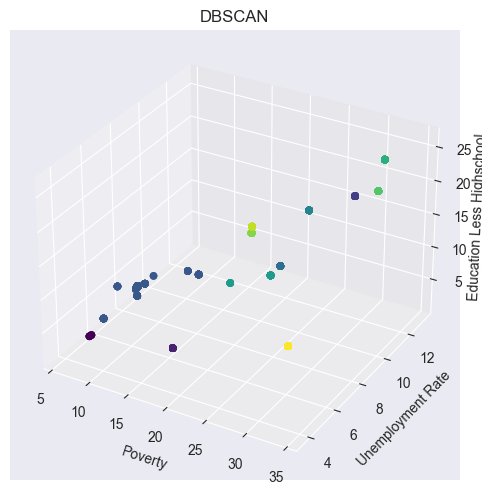

In [50]:
#DBSCAN of Poverty, unemployment rate, and education less high school
scaler = StandardScaler()

#Sample set taken due to size constraint
X_subset = df_geo.sample(n = 1000, random_state = 100)
X_sub = X_subset[['poverty', 'unemployment_rate', 'education_less_highschool']]

#Scale Data
X_scaled = scaler.fit_transform(X_sub)
X_scaled_df = pd.DataFrame(X_scaled, columns =['poverty', 'unemployment_rate', 'education_less_highschool'])

#eps radius of 0.7 set and a minimum of 20 points in the eps radius
dbscan = DBSCAN(eps = 0.7, min_samples = 10)
y_dbscan = dbscan.fit_predict(X_scaled_df)

X_subset['Cluster'] = y_dbscan

#Plot
fig = plt.figure(figsize = (7,5))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(X_subset['poverty'], X_subset['unemployment_rate'], X_subset['education_less_highschool'], c=X_subset['Cluster'], cmap = 'viridis', marker = 'o')
ax.set_xlabel('Poverty')
ax.set_ylabel('Unemployment Rate')
ax.set_zlabel('Education Less Highschool', labelpad = -2)
plt.title('DBSCAN')
plt.tight_layout()
plt.show()




The higher rates of people with education less than high school correlates with higher unemployement rate and poverty. Low poverty rates range across a wide span of unemployment rates, low to high, but also have an increase in grouping for lower rates of people with less than a high school education. 
This tracks with what we were expecting and have seen so far in our data.  

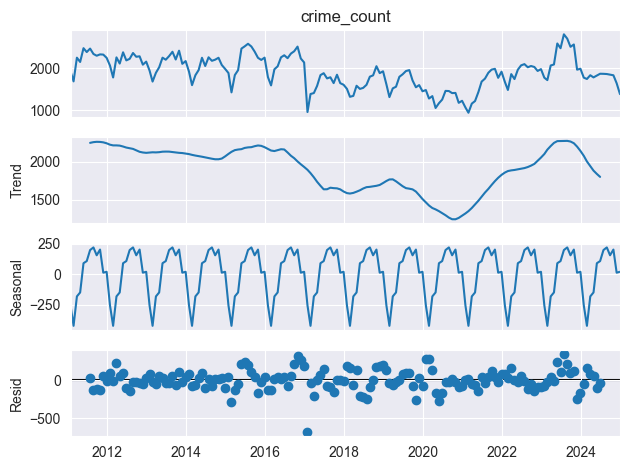

In [51]:
#Seasonal Decomp by Month

df_monthly = df_geo.resample('ME', on='CrimeDateTime').size().to_frame(name="crime_count")
df_monthly.index = pd.to_datetime(df_monthly.index) 


# Decomposition
decomp = sm.tsa.seasonal_decompose(df_monthly["crime_count"], model="additive", period=12)
decomp.plot()
plt.show()

Okay this is a pretty awesome graph.
The top graph is showing the raw crime count over time, before any decomposiiton.
The 'trend' graph is showing crime over time, but in a smoothed 'trend/pattern.' Looks like crimed overall trended down from 2016 to 2018, trended up for a year or so, and then back down to 2020. Then trended up again from 2020 to 2024.
The 'seasonal' graph is showing a clear, repeating trend. When we compare this to what we found earlier in crimes by month, we can see that there is a clear trend for more crimes to be committed in the late summer / early fall months, with the biggest dip in February. This repeates year after year.
Lastly the residual component shows what is left over after removing the trend and seasonal data. This would show random outliers or specific spikes (i.e., due to a protest that isn't annual). This seems to be relatively erratic, with no obvious spikes. There are a few outliers though - there's a very low datapoint around 2017. There also seems to potentially be some higher groups (though I cannot tell for sure) around 2016, 2020, and 2024. These could be related to presidential election time periods?

Next up we'll do some time series data. We'll do a bit of prep before deciding to move forward with either ARIMA or Prophet forecasting.

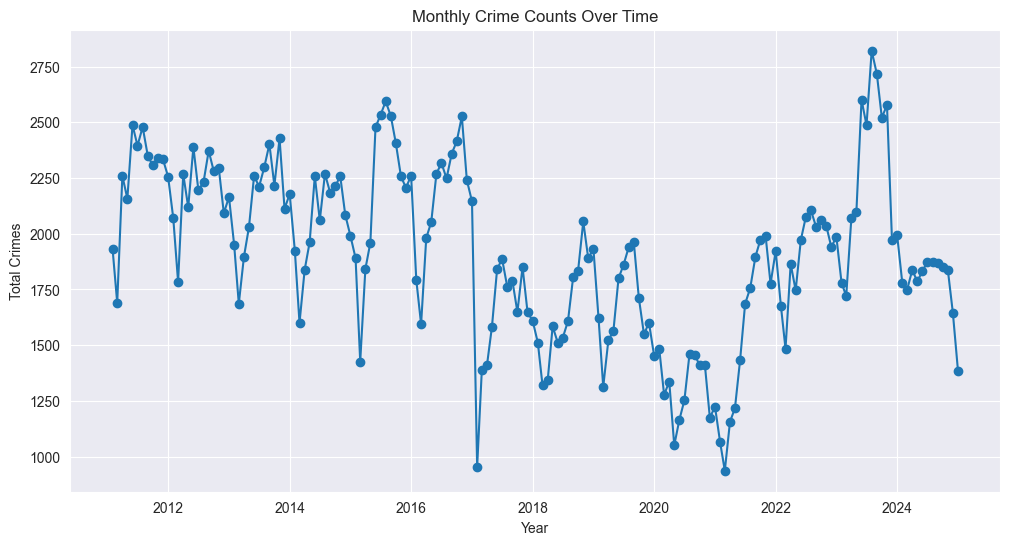

In [52]:
# Aggregate crime counts by month
df_monthly = df_geo.resample('ME', on='CrimeDateTime').size().to_frame(name="crime_count")

# Ensure datetime index
df_monthly.index = pd.to_datetime(df_monthly.index)

# Plot crime trends over time
plt.figure(figsize=(12,6))
plt.plot(df_monthly.index, df_monthly["crime_count"], marker='o', linestyle='-')
plt.title("Monthly Crime Counts Over Time")
plt.xlabel("Year")
plt.ylabel("Total Crimes")
plt.grid(True)
plt.show()

In [53]:
# Perform Augmented Dickey-Fuller test
adf_test = adfuller(df_monthly["crime_count"])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

ADF Statistic: -2.137751622114875
p-value: 0.22960782921948186


Since we know we have strong seasonality, and the data isn't stationary (since the ADF statistic is not significant), let's move forward with Prophet time series analyses. 

16:02:19 - cmdstanpy - INFO - Chain [1] start processing
16:02:19 - cmdstanpy - INFO - Chain [1] done processing


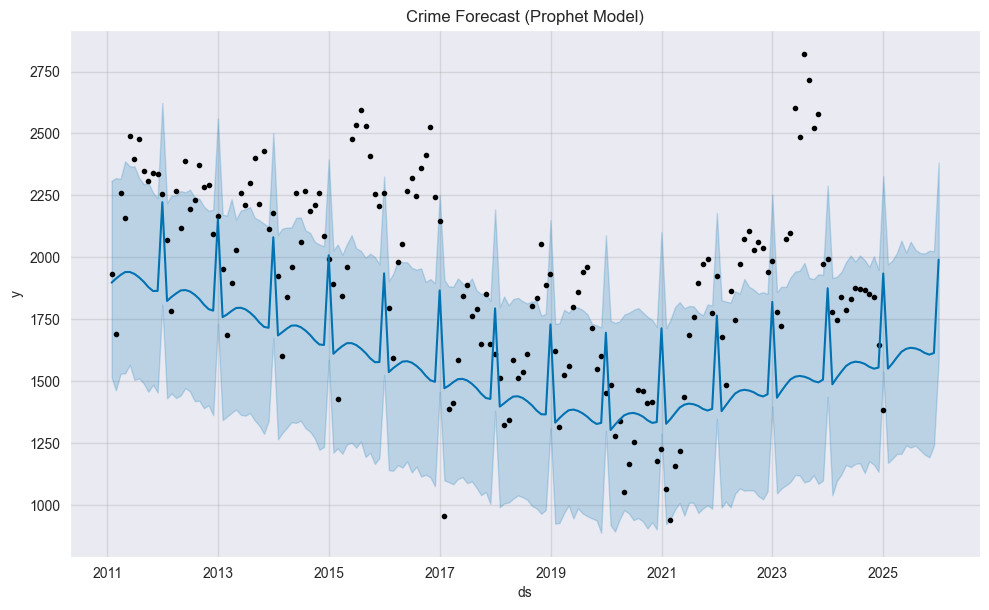

In [54]:
prophet_data = df_monthly.reset_index()[['CrimeDateTime', 'crime_count']]
prophet_data.columns = ['ds', 'y']

prophet_model = Prophet(yearly_seasonality=True, daily_seasonality=False)

prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=12, freq='ME')

forecast = prophet_model.predict(future)

prophet_model.plot(forecast)
plt.title("Crime Forecast (Prophet Model)")
plt.show()

Using Prophet to forecast based on our data, it appears we are expected to continue trending up in crime for the majorit of 2025. Seasonally, we would expect Februrary to be our lowest month of crime overall, and then a peak around August or so until October. 

And then lastly, here, adding a poverty choropleth map, since that specific socioeconomic variable stood out as the most correlated during out analysis. 

<Figure size 1200x800 with 0 Axes>

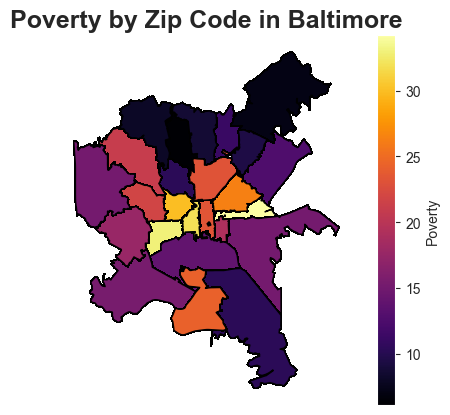

In [93]:
plt.figure(figsize=(12, 8))
df_geo.plot(column='poverty', cmap='inferno', legend=True,
            edgecolor='black',
            legend_kwds={'label': "Poverty"})

plt.title("Poverty by Zip Code in Baltimore", fontsize=18, weight='bold')
plt.axis("off")
plt.show()

<><><><><><><><><><><><><><><><><><>

AND NOWWWWWWWWWW MOVING INTO RESEARCH QUESTION #2 CODE







<><><><><><>

In [55]:
#starting with a few transformations:

#Binning CrimeDateTime into time categories
df_geo['CrimeDateTime'] = pd.to_datetime(df_geo['CrimeDateTime'], errors='coerce')
df_geo['Time_Category'] = pd.cut(
    df_geo['CrimeDateTime'].dt.hour,
    bins=[-1, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=True
)

# Normalize income, poverty, and education levels and combine them
df_geo['Socioeconomic_Index'] = (
        (df_geo['income_household_median'] / df_geo['income_household_median'].max()) -
        (df_geo['poverty'] / df_geo['poverty'].max()) +
        (df_geo['education_college_or_above'] / df_geo['education_college_or_above'].max())
)

# The 'VIOLENT_CR' column contains crime types (e.g., 'HOMICIDE', 'ROBBERY', etc.), not a binary indicator.
# Initially, the 'CrimeCode' column was used incorrectly for mapping violent crimes.
# Correct Approach: Map violent crimes directly from 'VIOLENT_CR'.

violent_crime_types = ['AGG. ASSAULT', 'HOMICIDE', 'RAPE', 'ROBBERY', 'SHOOTING']
df_geo['Binary_Violent_Crime'] = df_geo['VIOLENT_CR'].apply(lambda x: 1 if x in violent_crime_types else 0)

print("Target Variable Distribution:")
print(df_geo['Binary_Violent_Crime'].value_counts())

# Explanation:
# 0 represents Non-Violent Crimes
# 1 represents Violent Crimes

Target Variable Distribution:
Binary_Violent_Crime
0    238447
1     82793
Name: count, dtype: int64


In [56]:
#Prepare Features and Target for Modeling
features = ['Time_Category', 'PremiseType_Grouped', 'Socioeconomic_Index', 'income_household_median', 'poverty']
df_model = pd.get_dummies(df_geo[features], drop_first=True)
target = df_geo['Binary_Violent_Crime']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

#Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, target)

#plit the Balanced Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58     71404
           1       0.59      0.61      0.60     71665

    accuracy                           0.59    143069
   macro avg       0.59      0.59      0.59    143069
weighted avg       0.59      0.59      0.59    143069

Confusion Matrix:
 [[40760 30644]
 [28302 43363]]


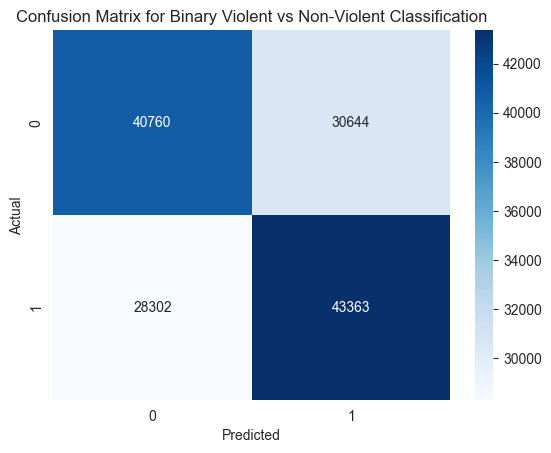

ROC-AUC Score: 0.6246194820788812


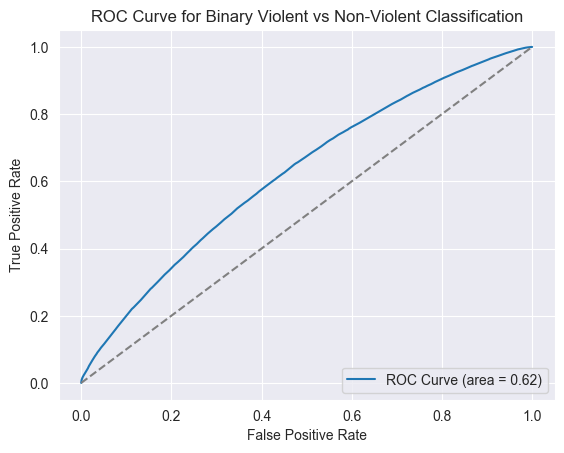

In [57]:
#Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#Visualize the Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Binary Violent vs Non-Violent Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Plot the ROC Curve for Binary Classification
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Violent vs Non-Violent Classification")
plt.legend(loc="lower right")
plt.show()

In [58]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [10, 20, None],  
    'min_samples_split': [2, 5], 
    'min_samples_leaf': [1, 2]
}
random_search = RandomizedSearchCV(
    rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1, verbose=1
)
random_search.fit(X_train, y_train)


print("Best Parameters:", random_search.best_params_)

#Evaluate the Tuned Random Forest Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20}
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.58      0.58     71404
           1       0.59      0.60      0.59     71665

    accuracy                           0.59    143069
   macro avg       0.59      0.59      0.59    143069
weighted avg       0.59      0.59      0.59    143069

Confusion Matrix:
 [[41289 30115]
 [28817 42848]]


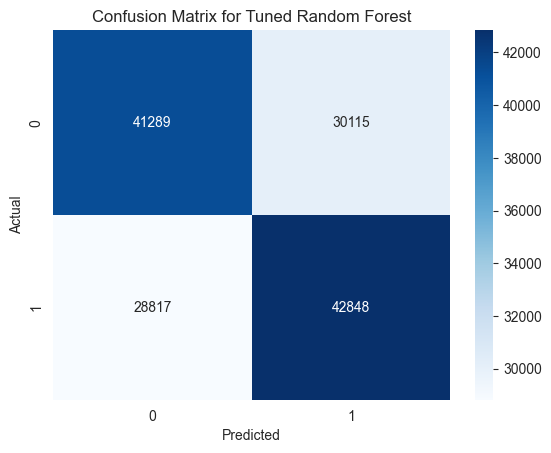

ROC-AUC Score: 0.6244789446668237


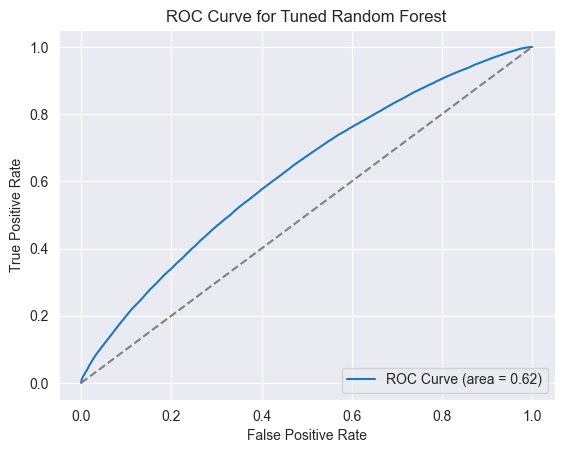

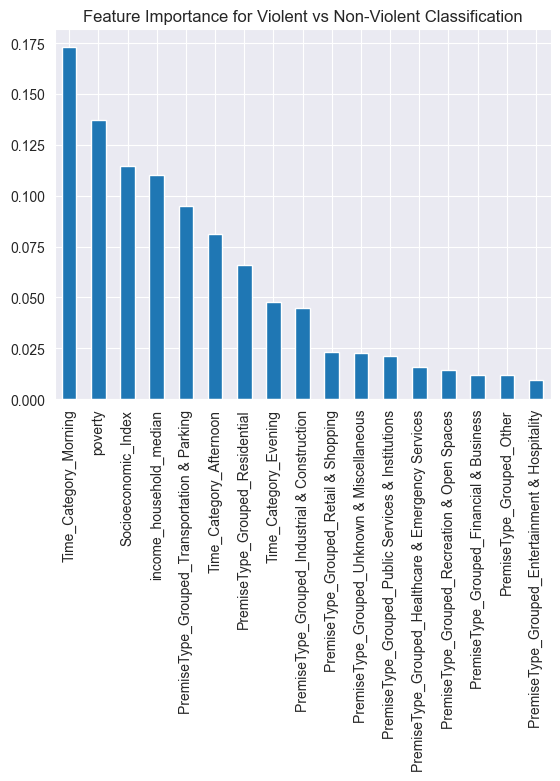

In [59]:
#Visualize the Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Plot the ROC Curve for the Tuned Model
y_proba = best_model.predict_proba(X_test)[:, 1]  # Get probability estimates for class 1 (Violent)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Tuned Random Forest")
plt.legend(loc="lower right")
plt.show()

#Feature Importance Visualization
feature_importances = pd.Series(best_model.feature_importances_, index=df_model.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', title='Feature Importance for Violent vs Non-Violent Classification')
plt.show()

In [62]:
#Train a Logistic Regression Model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

#Evaluate the Model
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.55      0.56     71404
           1       0.57      0.61      0.59     71665

    accuracy                           0.58    143069
   macro avg       0.58      0.58      0.58    143069
weighted avg       0.58      0.58      0.58    143069

Confusion Matrix:
 [[39133 32271]
 [28165 43500]]


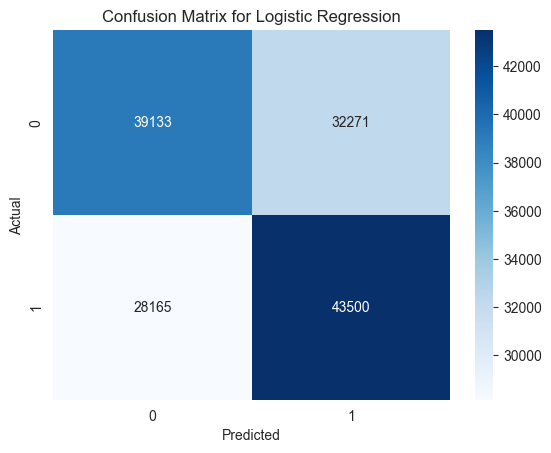

ROC-AUC Score: 0.6094606111655134


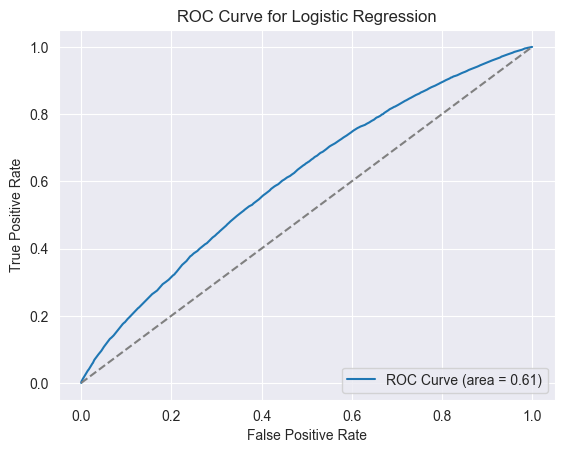

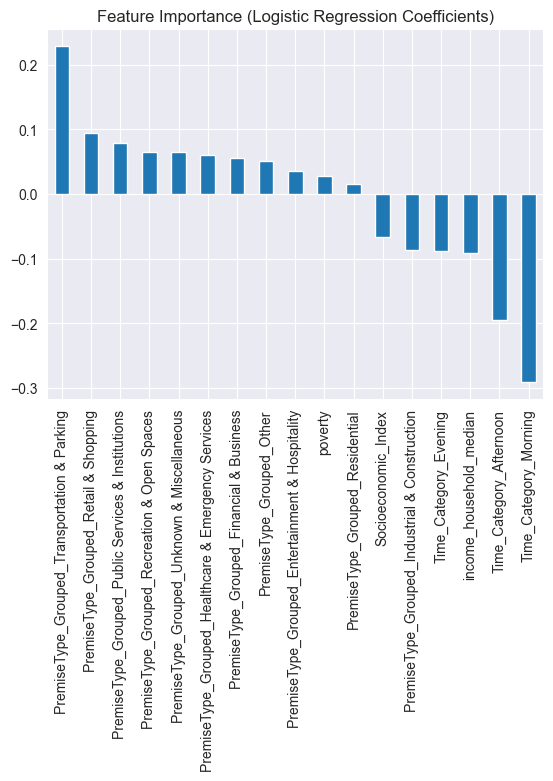

In [63]:
#Visualize the Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot the ROC Curve for Logistic Regression
y_proba = model.predict_proba(X_test)[:, 1]  # Get probability estimates for class 1 (Violent)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend(loc="lower right")
plt.show()

#Feature Importance (Coefficients)
coefficients = pd.Series(model.coef_[0], index=df_model.columns).sort_values(ascending=False)
coefficients.plot(kind='bar', title='Feature Importance (Logistic Regression Coefficients)')
plt.show()

Classification Report (XGBoost):
               precision    recall  f1-score   support

           0       0.59      0.57      0.58     71404
           1       0.59      0.61      0.60     71665

    accuracy                           0.59    143069
   macro avg       0.59      0.59      0.59    143069
weighted avg       0.59      0.59      0.59    143069

Confusion Matrix (XGBoost):
 [[40747 30657]
 [28227 43438]]
ROC-AUC Score (XGBoost): 0.6244242231844325


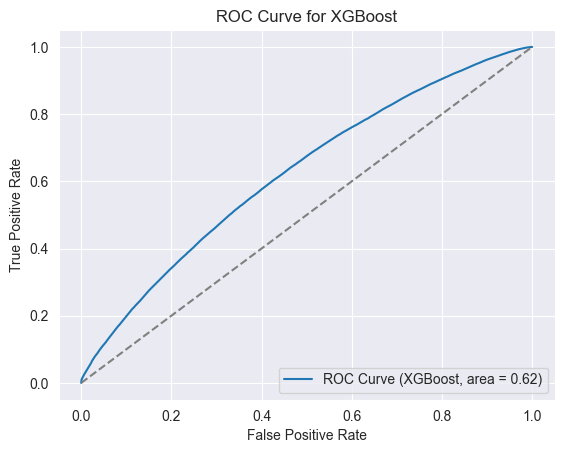

In [67]:
#Train an XGBoost Classifier
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

#Evaluate the XGBoost Model
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix (XGBoost):\n", confusion_matrix(y_test, y_pred_xgb))

#Plot the ROC Curve for XGBoost
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("ROC-AUC Score (XGBoost):", roc_auc_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f"ROC Curve (XGBoost, area = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost")
plt.legend(loc="lower right")
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.61      0.62     71404
           1       0.62      0.63      0.62     71665

    accuracy                           0.62    143069
   macro avg       0.62      0.62      0.62    143069
weighted avg       0.62      0.62      0.62    143069

Confusion Matrix:
 [[43729 27675]
 [26835 44830]]
ROC-AUC Score: 0.6747977102630246


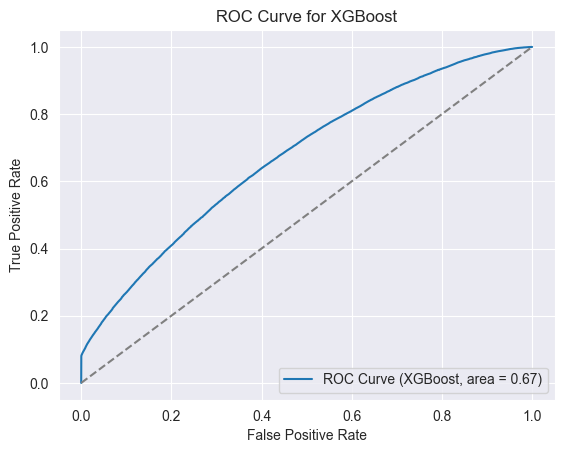

In [68]:
# Some more Feature Engineering
df_geo['day_of_week'] = df_geo['CrimeDateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
df_geo['is_weekend'] = df_geo['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df_geo['month'] = df_geo['CrimeDateTime'].dt.month
df_geo['season'] = df_geo['month'].apply(lambda x: 'winter' if x in [12, 1, 2] else
'spring' if x in [3, 4, 5] else
'summer' if x in [6, 7, 8] else 'fall')

# Create dummy variables for categorical features
df_model = pd.get_dummies(df_geo[['Time_Category', 'PremiseType_Grouped', 'Socioeconomic_Index',
                              'income_household_median', 'poverty', 'day_of_week', 'is_weekend', 'season']],
                          drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

#Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, target)

#Split the Balanced Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

#Train the XGBoost Classifier with Predefined Hyperparameters
xgb = XGBClassifier(
    n_estimators=200, max_depth=7, learning_rate=0.1, subsample=0.8, colsample_bytree=0.8, random_state=42
)
xgb.fit(X_train, y_train)

#Model Evaluation
y_pred = xgb.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

#Plot the ROC Curve for XGBoost
y_proba = xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (XGBoost, area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for XGBoost")
plt.legend(loc="lower right")
plt.show()

Classification Report (Fine-Tuned Logistic Regression):
               precision    recall  f1-score   support

           0       0.58      0.55      0.56     71404
           1       0.57      0.61      0.59     71665

    accuracy                           0.58    143069
   macro avg       0.58      0.58      0.58    143069
weighted avg       0.58      0.58      0.58    143069

Confusion Matrix (Fine-Tuned Logistic Regression):
 [[39098 32306]
 [28036 43629]]
ROC-AUC Score (Fine-Tuned Logistic Regression): 0.6092223961839077


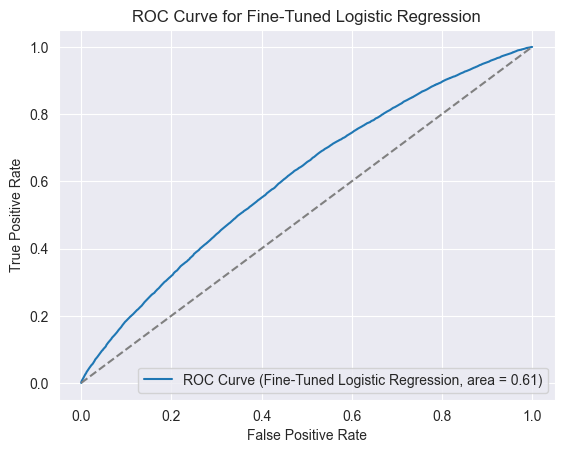

In [70]:
#Fine-Tune Logistic Regression with Cross-Validation
#using both L1 (Lasso) and L2 (Ridge) penalties
log_reg_cv = LogisticRegressionCV(
    Cs=10, 
    cv=5,  
    penalty='elasticnet', 
    solver='saga',
    l1_ratios=[0.1, 0.5, 0.9],  
    max_iter=1000,
    random_state=42
)
log_reg_cv.fit(X_train, y_train)

#Evaluate the Fine-Tuned Logistic Regression Model
y_pred_logreg_cv = log_reg_cv.predict(X_test)
print("Classification Report (Fine-Tuned Logistic Regression):\n", classification_report(y_test, y_pred_logreg_cv))
print("Confusion Matrix (Fine-Tuned Logistic Regression):\n", confusion_matrix(y_test, y_pred_logreg_cv))

#Plot the ROC Curve for Fine-Tuned Logistic Regression
y_proba_logreg_cv = log_reg_cv.predict_proba(X_test)[:, 1]
fpr_logreg_cv, tpr_logreg_cv, _ = roc_curve(y_test, y_proba_logreg_cv)
roc_auc_logreg_cv = roc_auc_score(y_test, y_proba_logreg_cv)
print("ROC-AUC Score (Fine-Tuned Logistic Regression):", roc_auc_logreg_cv)

plt.figure()
plt.plot(fpr_logreg_cv, tpr_logreg_cv, label=f"ROC Curve (Fine-Tuned Logistic Regression, area = {roc_auc_logreg_cv:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Fine-Tuned Logistic Regression")
plt.legend(loc="lower right")
plt.show()

In [74]:
#Prepare Features and Target
df_geo['Binary_Armed_Crime'] = df_geo['WEAPON'].apply(lambda x: 0 if x.strip().upper() == 'UNARMED' else 1)
features = ['Time_Category', 'PremiseType_Grouped', 'Socioeconomic_Index', 'income_household_median', 'poverty']
df_model = pd.get_dummies(df_geo[features], drop_first=True)
target = df_geo['Binary_Armed_Crime']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, target)

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

#Train a Random Forest Model
rf_armed = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf_armed.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [75]:
#Evaluate the Model
y_pred_armed = rf_armed.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_armed))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_armed))

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61     52883
           1       0.62      0.61      0.61     53297

    accuracy                           0.61    106180
   macro avg       0.61      0.61      0.61    106180
weighted avg       0.61      0.61      0.61    106180

Confusion Matrix:
 [[32696 20187]
 [20767 32530]]


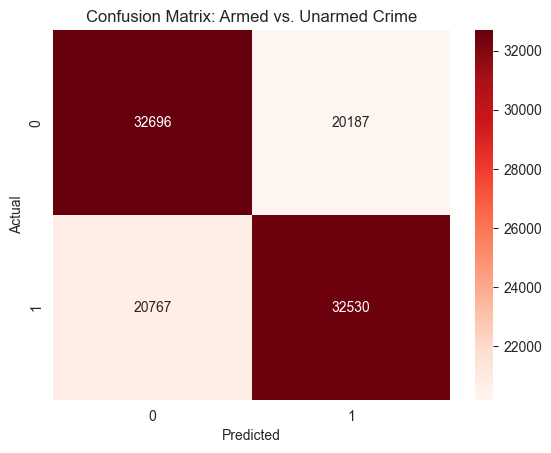

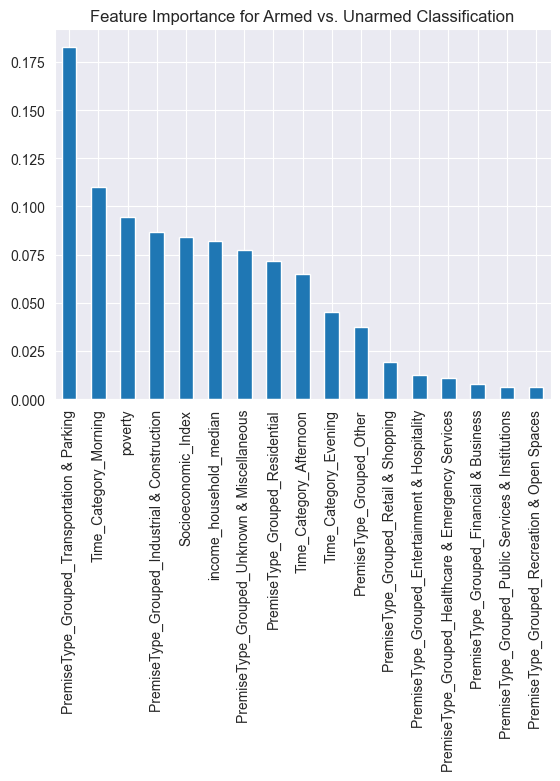

In [76]:
#Plot Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_armed), annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix: Armed vs. Unarmed Crime")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#Feature Importance
feature_importances = pd.Series(rf_armed.feature_importances_, index=df_model.columns).sort_values(ascending=False)
feature_importances.plot(kind='bar', title='Feature Importance for Armed vs. Unarmed Classification')
plt.show()

Classification Report (Fine-Tuned Logistic Regression):
               precision    recall  f1-score   support

           0       0.60      0.63      0.61     52883
           1       0.61      0.57      0.59     53297

    accuracy                           0.60    106180
   macro avg       0.60      0.60      0.60    106180
weighted avg       0.60      0.60      0.60    106180

Confusion Matrix (Fine-Tuned Logistic Regression):
 [[33438 19445]
 [22694 30603]]


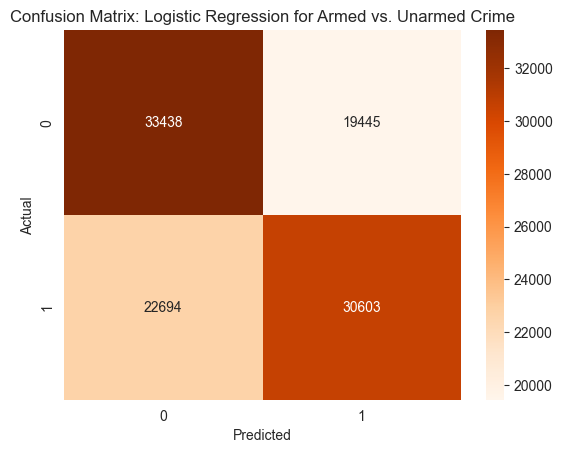

In [77]:
#Train Logistic Regression with Cross-Validation and Elastic Net Regularization
log_reg_cv = LogisticRegressionCV(
    Cs=10, 
    cv=5, 
    penalty='elasticnet',
    solver='saga', 
    l1_ratios=[0.1, 0.5, 0.9],
    max_iter=1000,
    random_state=42
)
log_reg_cv.fit(X_train, y_train)

#Evaluate the Logistic Regression Model
y_pred_logreg_cv = log_reg_cv.predict(X_test)
print("Classification Report (Fine-Tuned Logistic Regression):\n", classification_report(y_test, y_pred_logreg_cv))
print("Confusion Matrix (Fine-Tuned Logistic Regression):\n", confusion_matrix(y_test, y_pred_logreg_cv))

#Plot Confusion Matrix (Dark Red Theme)
sns.heatmap(confusion_matrix(y_test, y_pred_logreg_cv), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix: Logistic Regression for Armed vs. Unarmed Crime")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC-AUC Score (Fine-Tuned Logistic Regression): 0.6431388411842983


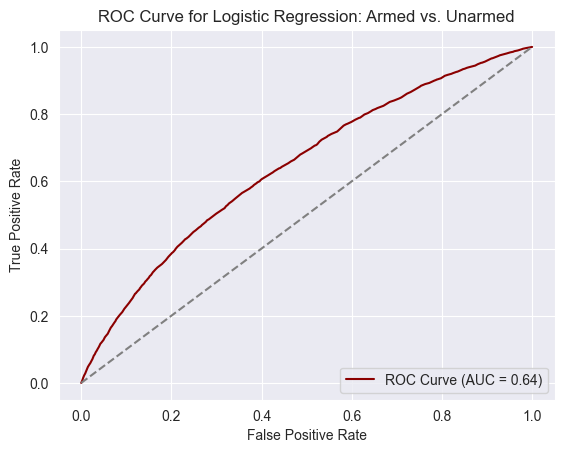

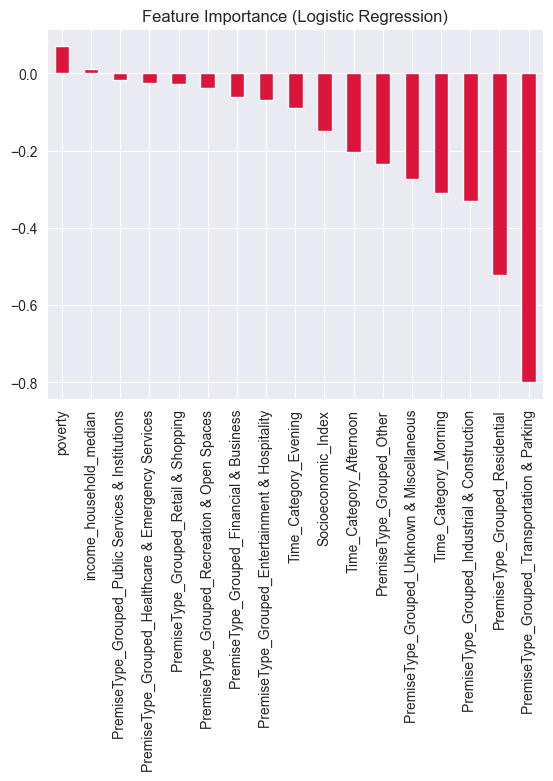

In [79]:
#Plot ROC Curve for Logistic Regression
y_proba_logreg_cv = log_reg_cv.predict_proba(X_test)[:, 1]
fpr_logreg_cv, tpr_logreg_cv, _ = roc_curve(y_test, y_proba_logreg_cv)
roc_auc_logreg_cv = roc_auc_score(y_test, y_proba_logreg_cv)
print("ROC-AUC Score (Fine-Tuned Logistic Regression):", roc_auc_logreg_cv)

plt.figure()
plt.plot(fpr_logreg_cv, tpr_logreg_cv, label=f"ROC Curve (AUC = {roc_auc_logreg_cv:.2f})", color="darkred")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression: Armed vs. Unarmed")
plt.legend(loc="lower right")
plt.show()

#Feature Importance (Logistic Regression Coefficients)
coefficients = pd.Series(log_reg_cv.coef_.flatten(), index=df_model.columns)
coefficients.sort_values(ascending=False).plot(kind='bar', color="crimson", title="Feature Importance (Logistic Regression)")
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.62      0.61     52883
           1       0.62      0.61      0.61     53297

    accuracy                           0.61    106180
   macro avg       0.61      0.61      0.61    106180
weighted avg       0.61      0.61      0.61    106180

Confusion Matrix:
 [[32616 20267]
 [20692 32605]]


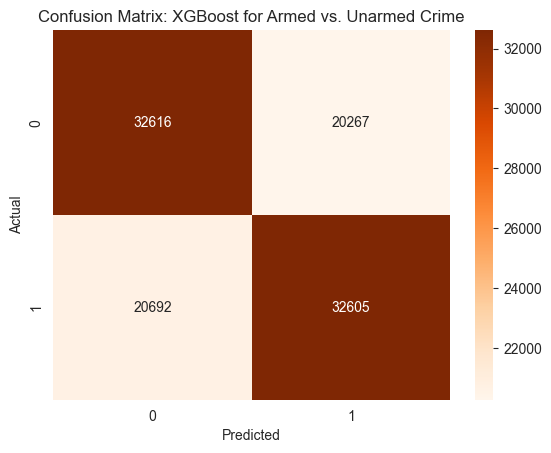

In [86]:
#Convert Target to Integer
y_balanced = y_balanced.astype(int)

#Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)


#Train XGBoost Model (Without Hyperparameter Tuning)
xgb_model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=200, 
    max_depth=6, 
    learning_rate=0.1, 
    subsample=0.8, 
    colsample_bytree=0.8,  
    random_state=42
)
xgb_model.fit(X_train, y_train)

#Evaluate XGBoost Model
y_pred_xgb = xgb_model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

#Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix: XGBoost for Armed vs. Unarmed Crime")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

ROC-AUC Score: 0.6585090318144665


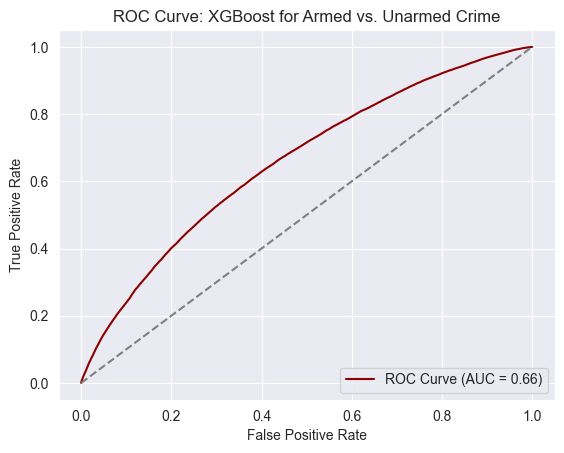

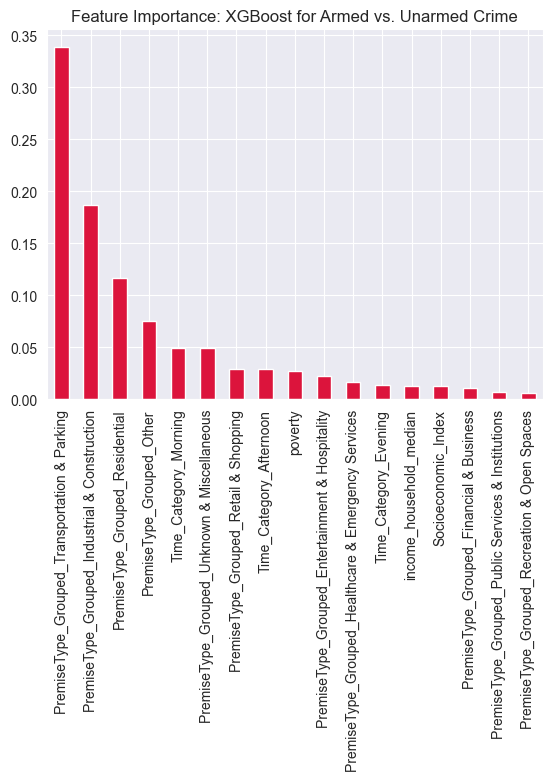

In [88]:
#ROC-AUC Score & Curve
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("ROC-AUC Score:", roc_auc_xgb)

plt.figure()
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_xgb:.2f})", color="darkred")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: XGBoost for Armed vs. Unarmed Crime")
plt.legend(loc="lower right")
plt.show()

#Feature Importance Visualization
xgb_importances = pd.Series(xgb_model.feature_importances_, index=df_model.columns).sort_values(ascending=False)
xgb_importances.plot(kind='bar', title='Feature Importance: XGBoost for Armed vs. Unarmed Crime', color="crimson")
plt.show()

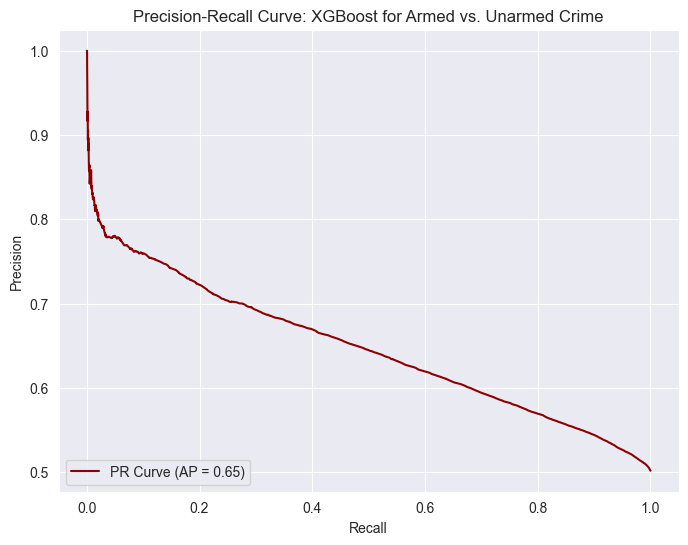

In [91]:
#Get Precision-Recall Values
precision, recall, _ = precision_recall_curve(y_test, y_proba_xgb)
avg_precision = average_precision_score(y_test, y_proba_xgb)

#Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AP = {avg_precision:.2f})", color="darkred")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve: XGBoost for Armed vs. Unarmed Crime")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

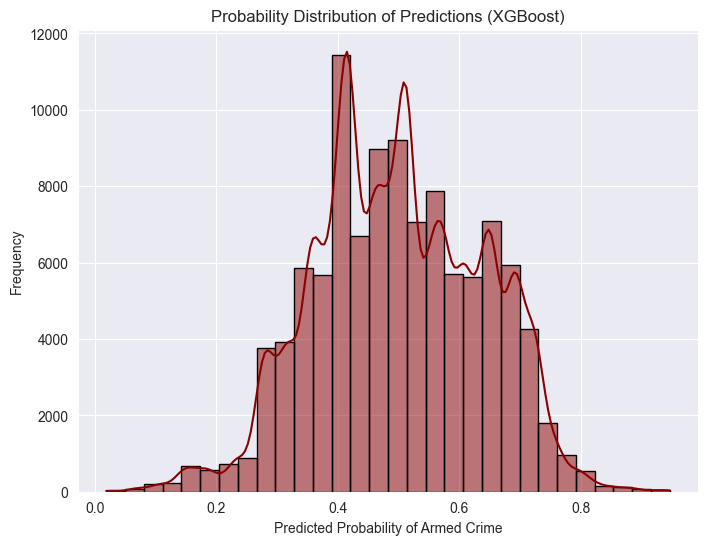

In [92]:
#Get Predicted Probabilities
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probability of being "Armed"

plt.figure(figsize=(8, 6))
sns.histplot(y_proba_xgb, bins=30, kde=True, color="darkred", edgecolor="black")

plt.xlabel("Predicted Probability of Armed Crime")
plt.ylabel("Frequency")
plt.title("Probability Distribution of Predictions (XGBoost)")

plt.show()

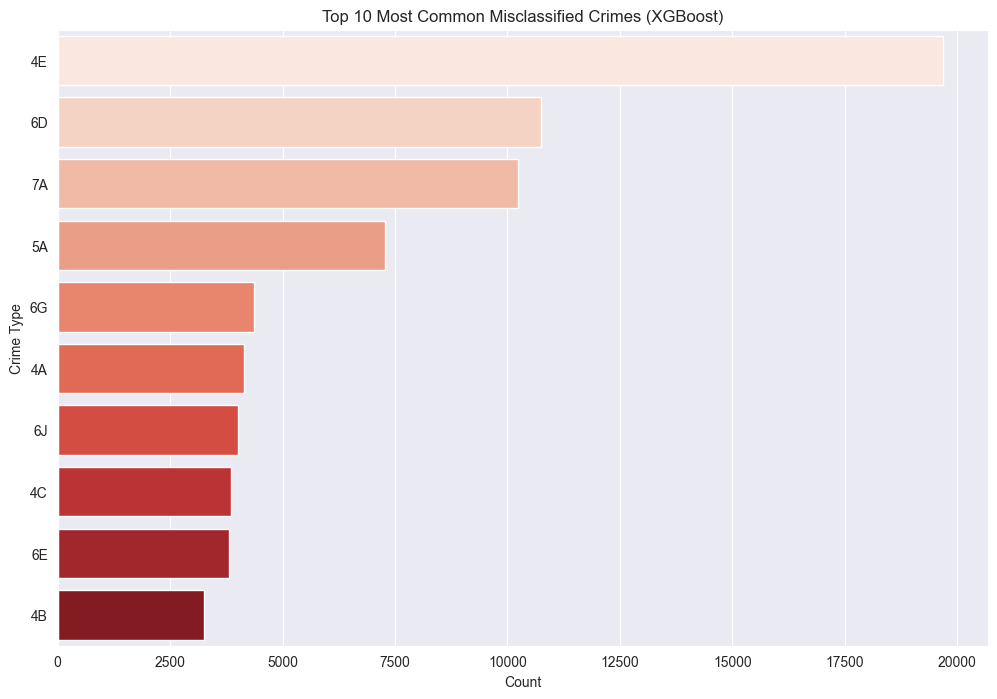

In [95]:
#Create DataFrame with Predictions
df_test_xgb = pd.DataFrame(X_test, columns=df_model.columns)
df_test_xgb["Actual"] = y_test
df_test_xgb["Predicted"] = y_pred_xgb

#Reset index before merging
df_test_xgb = df_test_xgb.reset_index(drop=True)
df_original = df_geo[["CrimeCode"]].reset_index(drop=True)

#Add Crime Type from Original Dataset
df_test_xgb["CrimeType"] = df_original.loc[df_test_xgb.index, "CrimeCode"]

#Identify Misclassified Crimes
misclassified_xgb = df_test_xgb[df_test_xgb["Actual"] != df_test_xgb["Predicted"]]

#Count Misclassified Crimes by Type and Select Top 10
crime_counts = misclassified_xgb["CrimeType"].value_counts().nlargest(10)

#Plot Misclassified Crimes (Top 10)
plt.figure(figsize=(12, 8))
sns.barplot(y=crime_counts.index, x=crime_counts.values, hue=crime_counts.index, palette="Reds", legend=False)

#Labels, Title, and Formatting
plt.title("Top 10 Most Common Misclassified Crimes (XGBoost)")
plt.xlabel("Count")
plt.ylabel("Crime Type")
plt.xticks(rotation=0)
plt.yticks(fontsize=10)
plt.show()

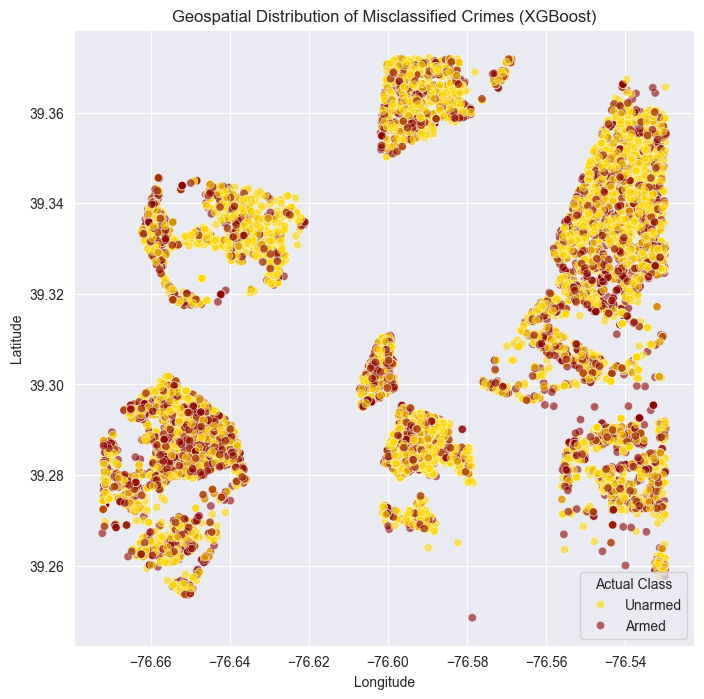

In [97]:
#Create DataFrame with Predictions
df_test_xgb = pd.DataFrame(X_test, columns=df_model.columns)
df_test_xgb["Actual"] = y_test
df_test_xgb["Predicted"] = y_pred_xgb

#Reset index before merging
df_test_xgb = df_test_xgb.reset_index(drop=True)
df_original = df_geo[["Latitude", "Longitude"]].reset_index(drop=True)

#Merge Latitude & Longitude from the original dataset
df_test_xgb["Latitude"] = df_original.loc[df_test_xgb.index, "Latitude"]
df_test_xgb["Longitude"] = df_original.loc[df_test_xgb.index, "Longitude"]

#Filter Misclassified Crimes
misclassified_xgb = df_test_xgb[df_test_xgb["Actual"] != df_test_xgb["Predicted"]]

#Plot Geospatial Heatmap
plt.figure(figsize=(8, 8))
scatter = sns.scatterplot(
    x=misclassified_xgb["Longitude"],
    y=misclassified_xgb["Latitude"],
    hue=misclassified_xgb["Actual"], 
    palette={0: "gold", 1: "darkred"},
    alpha=0.6
)

#Improve Legend Clarity
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles, ["Unarmed", "Armed"], title="Actual Class", loc="lower right")

plt.title("Geospatial Distribution of Misclassified Crimes (XGBoost)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()